In [2]:
import math 
import torch
import torchvision
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.tensorboard import SummaryWriter
from datetime import datetime

import torch.nn as nn
import torch.nn.functional as F

from torchinfo import summary

from utils import *

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(device, device.type)

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=torchvision.transforms.ToTensor())
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=torchvision.transforms.ToTensor())

cuda cuda


In [2]:
!pip install einops

In [3]:
!hostname

juliet2


In [5]:
#emulating patch size of 4*4 using CNN 

height = 32
width = 32

color_channels = 3

patch_size = 4

# calculate the number of patches for the image
nb_patches = height * width // patch_size**2# 64 here

#use 2D conv layer generate patches
patchenizer = nn.Conv2d(in_channels=color_channels, out_channels=nb_patches, kernel_size=patch_size, stride=patch_size)
print(patchenizer)


Conv2d(3, 64, kernel_size=(4, 4), stride=(4, 4))


In [3]:
#torch module that takes an image and returns a sequence of patches where the size of each patch is 4*4 and the output
class PatchEmbedding(nn.Module):
    def __init__(self, patch_size=4, in_channels=3, embed_dim=64, img_size=32, nb_patches=0):
        super().__init__()
        self.patch_size = patch_size
        self.in_channels = in_channels
        self.embed_dim = embed_dim

        if nb_patches == 0:
            self.num_patches = (img_size // patch_size) ** 2
        else:
            self.nb_patches = nb_patches
        # Conv2d replaces manually extracting patches
        self.proj = nn.Conv2d(
            in_channels=self.in_channels, 
            out_channels=self.embed_dim, 
            kernel_size=self.patch_size, 
            stride=self.patch_size
        )
        
    def forward(self, x):
        x = self.proj(x)
        x = x.flatten(2)
        #permute to have the batch size first
        x = x.permute(0, 2, 1) 
        #print(x.shape)
        return x

In [6]:
#take one image as tensor from train loader
image, _ = trainset[0]
print(image.shape)

patch_size = 4

color_channels = patch_size**2

# calculate the number of patches for the image
nb_patches = height * width // patch_size**2

#patch_embedding = PatchEmbedding(patch_size=patch_size, 
#                                 in_channels=color_channels, 
#                                 nb_patch=16)
#patches = patch_embedding(image)

patch_embed = PatchEmbedding(patch_size=4, in_channels=3, embed_dim=64, img_size=32, nb_patches=nb_patches)

image = image.unsqueeze(0)
print("Image Shape with Batch:", image.shape)

patches = patch_embed(image)

torch.Size([3, 32, 32])
Image Shape with Batch: torch.Size([1, 3, 32, 32])


In [7]:
def scaled_dot_product(q, k, v):
    d_k = q.size()[-1]
    #multiplication matricielle entre q et k
    attn_logits = q @ k.transpose(-2, -1)
    #scaling avec d_k (voir equation)
    attn_logits *= (1.0 / math.sqrt(d_k))
    #faire le softmax sur la dernière dimension
    attention = F.softmax(attn_logits, dim=-1)
    #multiplication matricielle avec v
    values = attention @ v
    return values

In [8]:
seq_len, d_k = 3, 2
q = torch.randn(seq_len, d_k)
k = torch.randn(seq_len, d_k)
v = torch.randn(seq_len, d_k)
values = scaled_dot_product(q, k, v)
print("Q\n", q.shape)
print("K\n", k.shape)
print("V\n", v.shape)
print("Values\n", values.shape)
#doit correspondre à la même shape

Q
 torch.Size([3, 2])
K
 torch.Size([3, 2])
V
 torch.Size([3, 2])
Values
 torch.Size([3, 2])


In [9]:
#do q k v projection with 3 nn.linear instead of just one mlp with 3 outputs (q, k, v heads)
class dumb_qkv_proj(nn.Module):
    def __init__(self, d_in, d_out):
        super().__init__()
        self.d_in = d_in
        self.d_out = d_out
        self.q = nn.Linear(self.d_in, self.d_out)
        self.k = nn.Linear(self.d_in, self.d_out)
        self.v = nn.Linear(self.d_in, self.d_out)
        
    def forward(self, x):
        q = self.q(x)
        k = self.k(x)
        v = self.v(x)
        return q, k, v

In [10]:
class qkv_proj(nn.Module):
    def __init__(self, d_in, d_out):
        super().__init__()
        self.d_in = d_in
        self.d_out = d_out
        self.proj = nn.Linear(self.d_in, self.d_out * 3)
    def forward(self, x):
        x = self.proj(x)
        return x.chunk(3, dim=-1)

In [11]:
proj = qkv_proj(d_in=2, d_out=2)
res = proj(values)
print(len(res))
q, k, v = res
print("Q\n", q.shape)
print("K\n", k.shape)
print("V\n", v.shape)

3
Q
 torch.Size([3, 2])
K
 torch.Size([3, 2])
V
 torch.Size([3, 2])


In [12]:
class qkv_proj(nn.Module):
    def __init__(self, d_in, d_out, num_heads):
        super().__init__()
        self.num_heads = num_heads
        self.d_in = d_in
        self.d_out = d_out

        self.proj = nn.Linear(self.d_in, self.d_out * 3)
    def forward(self, x):
        batch_size, seq_length, _ = x.size()
        qkv = self.proj(x)
        qkv = qkv.reshape(batch_size, seq_length, self.num_heads, -1)
        #permute Batch, Head, SeqLen, Dims
        qkv = qkv.permute(0, 2, 1, 3) 
        return qkv.chunk(3, dim=-1)

In [13]:
q,k,v = qkv_proj(32, 32*3, 4)(torch.randn(1,64,32))
q.shape, k.shape, v.shape

(torch.Size([1, 4, 64, 24]),
 torch.Size([1, 4, 64, 24]),
 torch.Size([1, 4, 64, 24]))

In [14]:
class MultiheadAttention(nn.Module):
    def __init__(self, input_dim, embed_dim, num_heads):
        super().__init__()
        #ps: juste pour vérifier que votre dimension
        #   match bien le nombre de tête...
        assert embed_dim % num_heads == 0

        self.embed_dim = embed_dim
        self.num_heads = num_heads

        #in_proj - votre fonction qkv_proj créé précédement
        self.in_proj = qkv_proj(input_dim, embed_dim, num_heads)
        
        self.o_proj = nn.Linear(embed_dim, embed_dim)


    def forward(self, x):
        batch_size, seq_length, _ = x.size()
        q, k, v = self.in_proj(x)
        #print(q.shape, k.shape, v.shape)
        #appeler votre fonction scaled_dot_product
        attn = scaled_dot_product(q, k, v)
        #print(attn.shape)
        #Permute back
        #Votre position de départ : [Batch, Head, SeqLen, Dims]
        #Permute dans la nouvelle dim : [Batch, SeqLen, Head, Dims]
        #(B, nh, T, hs) x (B, nh, hs, T) -> (B, nh, T, T)
        attn = attn.permute(0, 2, 1, 3)
        #print(attn.shape)
        
        #reshape pour retirer la dimension "head".
        #aide : position de départ [Batch, SeqLen, Head, Dims]
        # position d'arrivée [Batch, SeqLen, self.embed_dim]
        attn = attn.reshape(batch_size, seq_length, self.embed_dim)
        #print(attn.shape)
        out = self.o_proj(attn)

        return out

In [15]:
net = MultiheadAttention(64, 64, 4)
net(torch.randn(1,16*16,64)).shape

torch.Size([1, 256, 64])

In [16]:
net = MultiheadAttention(64, 256, 4)
net(torch.randn(1,16*16,64)).shape

torch.Size([1, 256, 256])

In [17]:
class FeedForward(nn.Module):
    def __init__(self, dim, hidden_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(dim, hidden_dim),
            nn.GELU(),
            nn.Linear(hidden_dim, dim)
        )
    def forward(self, x):
        return self.net(x)

In [18]:
class Transformer(nn.Module):
    def __init__(self, input_dim, num_heads, hidden_dim):
        super().__init__()

        # Multi-head Attention
        self.attention = MultiheadAttention(input_dim=input_dim, embed_dim=input_dim, num_heads=num_heads)
        self.norm1 = nn.LayerNorm(input_dim)  # Normalisation après l'attention

        # Feed Forward
        self.ff = FeedForward(input_dim, hidden_dim)
        self.norm2 = nn.LayerNorm(input_dim)  # Normalisation après le feed forward

    def forward(self, x):
        # Multi-head Attention
        attn_out = self.attention(x)
        x = self.norm1(x + attn_out)

        # Feed Forward
        ff_out = self.ff(x)
        x = self.norm2(x + ff_out)

        return x

In [19]:
x = torch.randn(1, 64, 128)

transformer = Transformer(input_dim=128, num_heads=8, hidden_dim=256)

output = transformer(x)
print(output.shape)

print("image:", image.shape)
patches = patch_embed(image)
print("pacthes:", patches.shape)
transformer = Transformer(input_dim=64, num_heads=8, hidden_dim=256)
output = transformer(patches)
print(output.shape)

torch.Size([1, 64, 128])
image: torch.Size([1, 3, 32, 32])
pacthes: torch.Size([1, 64, 64])
torch.Size([1, 64, 64])


In [20]:
class TowerViT(nn.Module):
    def __init__(self, image_size, patch_size, in_channels, embed_dim, num_heads, hidden_dim, num_transformers, num_classes):
        super().__init__()

        self.patch_embedding = PatchEmbedding(patch_size=patch_size, 
                                              in_channels=in_channels, 
                                              nb_patches=((image_size*image_size) // patch_size) ** 2)

        num_patches = (image_size // patch_size) ** 2
        self.class_token = nn.Parameter(torch.randn(1, 1, embed_dim))
        self.pos_embedding = nn.Parameter(torch.randn(1, num_patches + 1, embed_dim))

        #stacking n number of transformers into a single sequential
        self.transformers = nn.Sequential(*[Transformer(embed_dim, num_heads, hidden_dim) for _ in range(num_transformers)])
        self.norm = nn.LayerNorm(embed_dim)

        self.mlp_head = nn.Sequential(
            nn.Linear(embed_dim, hidden_dim),
            nn.GELU(),
            nn.Linear(hidden_dim, num_classes)
        )

    def forward(self, x):
        batch_size = x.shape[0]

        x = self.patch_embedding(x)
        
        # Ajout du token de classification
        cls_tokens = self.class_token.expand(batch_size, -1, -1)  # (batch, 1, embed_dim)
        x = torch.cat([cls_tokens, x], dim=1)  # (batch, num_patches + 1, embed_dim)
        
        # Ajout de l'embedding positionnel
        x += self.pos_embedding

        x = self.transformers(x)
        x = self.norm(x)

        # Classification (on récupère seulement le token [CLS])
        cls_out = x[:, 0]
        return self.mlp_head(cls_out)


The ViT model was itself created as a combination of the specifications of the instructions for this project as well as insights I was able to gather from the paper which introduced vision transformers ("AN IMAGE IS WORTH 16X16 WORDS: TRANSFORMERS FOR IMAGE RECOGNITION AT SCALE", https://arxiv.org/abs/2010.11929).  
The architecture in the paper which reflects parts of this implementation are as follows :
![vit_arch](vit_arch.png)

In [21]:
class ViT(nn.Module):
    def __init__(self, image_size, patch_size, in_channels, in_embed_dims, out_embed_dims, num_heads, hidden_dims, num_transformers, num_classes):
        super().__init__()

        assert len(in_embed_dims) == num_transformers, "Mismatch: in_embed_dims length must match num_transformers"
        assert len(out_embed_dims) == num_transformers, "Mismatch: out_embed_dims length must match num_transformers"
        assert len(hidden_dims) == num_transformers, "Mismatch: hidden_dims length must match num_transformers"
        
        num_patches = ((image_size*image_size) // patch_size) ** 2
        self.class_token = nn.Parameter(torch.randn(1, 1, in_embed_dims[0]))
        self.pos_embedding = nn.Parameter(torch.randn(1, num_patches + 1, in_embed_dims[0]))

        # Patch Embedding
        self.patch_embedding = PatchEmbedding(patch_size=patch_size, 
                                              in_channels=in_channels, 
                                              nb_patches=num_patches)

        self.transformers = nn.ModuleList()
        for i in range(num_transformers):
            transformer = Transformer(in_embed_dims[i], num_heads[i], hidden_dims[i])
            self.transformers.append(transformer)

            if in_embed_dims[i] != out_embed_dims[i]:  # Changement de dimension si nécessaire
                self.transformers.append(nn.Linear(in_embed_dims[i], out_embed_dims[i]))

        last_embed_dim = out_embed_dims[-1]

        self.norm = nn.LayerNorm(last_embed_dim)

        self.mlp_head = nn.Sequential(
            nn.Linear(last_embed_dim, hidden_dims[-1]),
            nn.ReLU(),
            nn.Linear(hidden_dims[-1], num_classes)
        )

    def forward(self, x):
        batch_size, channels, width, height = x.shape

        # Patch Embedding
        x = self.patch_embedding(x)

        # Ajout du token de classification
        cls_tokens = self.class_token.expand(batch_size, -1, -1)
        x = torch.cat([cls_tokens, x], dim=1)
        #x += self.pos_embedding

        for layer in self.transformers:
            x = layer(x)

        x = self.norm(x)

        # Classification (on prend le token CLS)
        cls_out = x[:, 0]
        return self.mlp_head(cls_out)

In [34]:
image_size = 32
patch_size = 4
in_channels = 3

embed_dim = 64
hidden_dim = 128

n_heads = 4
num_transformers = 3

num_classes = 10

towervit = TowerViT(image_size, patch_size, in_channels, embed_dim, n_heads, hidden_dim, num_transformers, num_classes)

x = torch.randn(1, 3, 32, 32)
output = towervit(x)
print(output.shape)

torch.Size([1, 10])


In [35]:
print(summary(towervit, (1, in_channels, image_size, image_size)))

Layer (type:depth-idx)                   Output Shape              Param #
TowerViT                                 [1, 10]                   4,224
├─PatchEmbedding: 1-1                    [1, 64, 64]               --
│    └─Conv2d: 2-1                       [1, 64, 8, 8]             3,136
├─Sequential: 1-2                        [1, 65, 64]               --
│    └─Transformer: 2-2                  [1, 65, 64]               --
│    │    └─MultiheadAttention: 3-1      [1, 65, 64]               16,640
│    │    └─LayerNorm: 3-2               [1, 65, 64]               128
│    │    └─FeedForward: 3-3             [1, 65, 64]               16,576
│    │    └─LayerNorm: 3-4               [1, 65, 64]               128
│    └─Transformer: 2-3                  [1, 65, 64]               --
│    │    └─MultiheadAttention: 3-5      [1, 65, 64]               16,640
│    │    └─LayerNorm: 3-6               [1, 65, 64]               128
│    │    └─FeedForward: 3-7             [1, 65, 64]            

In [32]:
BATCH_SIZE = 128
epochs = 200
learning_rate = 3e-4

towervit = towervit.to(device)

#using the same optimizer as in the ViT paper
opt = torch.optim.SGD(towervit.parameters(), lr=learning_rate, momentum=0.9)
criterion = nn.CrossEntropyLoss()class_labels = [
    "airplane", "automobile", "bird", "cat", "deer",
    "dog", "frog", "horse", "ship", "truck"
]
test_and_display_random_images(vit, testset, num_images=10, class_labels=class_labels, device=device)

train_loader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True, pin_memory=True)
test_loader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE, pin_memory=True)

timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
writer = SummaryWriter('runs/towerVIT_trainer_validation_{}'.format(timestamp))
training_and_validation_loop(towervit, train_loader, test_loader, epochs, writer, device, opt, timestamp, flatten=False)

Epoch 1


Training: 100%|██████████| 391/391 [00:20<00:00, 18.81it/s]


Correct: 1314, Total: 10000, Accuracy: 0.13
Accuracy: 13.139999999999999% (0.1314)
Loss: 2.302157866327386


Validation: 100%|██████████| 79/79 [00:02<00:00, 30.13it/s]


LOSS train 2.302157866327386 valid 2.272792100906372
Saving model
Epoch 2


Training: 100%|██████████| 391/391 [00:16<00:00, 23.85it/s]


Correct: 1443, Total: 10000, Accuracy: 0.14
Accuracy: 14.430000000000001% (0.1443)
Loss: 2.301443940714786


Validation: 100%|██████████| 79/79 [00:02<00:00, 36.68it/s]


LOSS train 2.301443940714786 valid 2.2720038890838623
Saving model
Epoch 3


Training: 100%|██████████| 391/391 [00:14<00:00, 27.32it/s]


Correct: 1439, Total: 10000, Accuracy: 0.14
Accuracy: 14.39% (0.1439)
Loss: 2.3008214674497904


Validation: 100%|██████████| 79/79 [00:01<00:00, 41.10it/s]


LOSS train 2.3008214674497904 valid 2.2710940837860107
Saving model
Epoch 4


Training: 100%|██████████| 391/391 [00:12<00:00, 31.06it/s]


Correct: 1241, Total: 10000, Accuracy: 0.12
Accuracy: 12.41% (0.1241)
Loss: 2.2990635068793046


Validation: 100%|██████████| 79/79 [00:01<00:00, 47.18it/s]


LOSS train 2.2990635068793046 valid 2.270015001296997
Saving model
Epoch 5


Training: 100%|██████████| 391/391 [00:11<00:00, 33.21it/s]


Correct: 1700, Total: 10000, Accuracy: 0.17
Accuracy: 17.0% (0.17)
Loss: 2.2982811551345024


Validation: 100%|██████████| 79/79 [00:01<00:00, 47.25it/s]


LOSS train 2.2982811551345024 valid 2.268653631210327
Saving model
Epoch 6


Training: 100%|██████████| 391/391 [00:11<00:00, 33.09it/s]


Correct: 1718, Total: 10000, Accuracy: 0.17
Accuracy: 17.18% (0.1718)
Loss: 2.29637925248397


Validation: 100%|██████████| 79/79 [00:01<00:00, 41.46it/s]


LOSS train 2.29637925248397 valid 2.2667291164398193
Saving model
Epoch 7


Training: 100%|██████████| 391/391 [00:11<00:00, 33.20it/s]


Correct: 1604, Total: 10000, Accuracy: 0.16
Accuracy: 16.04% (0.1604)
Loss: 2.2933957702235173


Validation: 100%|██████████| 79/79 [00:01<00:00, 41.33it/s]


LOSS train 2.2933957702235173 valid 2.2640562057495117
Saving model
Epoch 8


Training: 100%|██████████| 391/391 [00:10<00:00, 37.48it/s]


Correct: 1623, Total: 10000, Accuracy: 0.16
Accuracy: 16.23% (0.1623)
Loss: 2.2891778569472465


Validation: 100%|██████████| 79/79 [00:01<00:00, 45.41it/s]


LOSS train 2.2891778569472465 valid 2.2601821422576904
Saving model
Epoch 9


Training: 100%|██████████| 391/391 [00:10<00:00, 35.97it/s]


Correct: 1582, Total: 10000, Accuracy: 0.16
Accuracy: 15.82% (0.1582)
Loss: 2.2856709455188953


Validation: 100%|██████████| 79/79 [00:01<00:00, 41.36it/s]


LOSS train 2.2856709455188953 valid 2.253941297531128
Saving model
Epoch 10


Training: 100%|██████████| 391/391 [00:10<00:00, 35.76it/s]


Correct: 1707, Total: 10000, Accuracy: 0.17
Accuracy: 17.07% (0.1707)
Loss: 2.2730193012639095


Validation: 100%|██████████| 79/79 [00:01<00:00, 41.59it/s]


LOSS train 2.2730193012639095 valid 2.2438485622406006
Saving model
Epoch 11


Training: 100%|██████████| 391/391 [00:11<00:00, 35.16it/s]


Correct: 1803, Total: 10000, Accuracy: 0.18
Accuracy: 18.029999999999998% (0.1803)
Loss: 2.2611109959451774


Validation: 100%|██████████| 79/79 [00:01<00:00, 40.74it/s]


LOSS train 2.2611109959451774 valid 2.2261393070220947
Saving model
Epoch 12


Training: 100%|██████████| 391/391 [00:10<00:00, 36.89it/s]


Correct: 1726, Total: 10000, Accuracy: 0.17
Accuracy: 17.26% (0.1726)
Loss: 2.2312810170023063


Validation: 100%|██████████| 79/79 [00:01<00:00, 47.47it/s]


LOSS train 2.2312810170023063 valid 2.1966776847839355
Saving model
Epoch 13


Training: 100%|██████████| 391/391 [00:10<00:00, 37.27it/s]


Correct: 1822, Total: 10000, Accuracy: 0.18
Accuracy: 18.22% (0.1822)
Loss: 2.1862716549321224


Validation: 100%|██████████| 79/79 [00:01<00:00, 46.63it/s]


LOSS train 2.1862716549321224 valid 2.1564977169036865
Saving model
Epoch 14


Training: 100%|██████████| 391/391 [00:10<00:00, 36.36it/s]


Correct: 1973, Total: 10000, Accuracy: 0.20
Accuracy: 19.73% (0.1973)
Loss: 2.157031410618832


Validation: 100%|██████████| 79/79 [00:01<00:00, 41.53it/s]


LOSS train 2.157031410618832 valid 2.1213834285736084
Saving model
Epoch 15


Training: 100%|██████████| 391/391 [00:10<00:00, 35.68it/s]


Correct: 2057, Total: 10000, Accuracy: 0.21
Accuracy: 20.57% (0.2057)
Loss: 2.131949776097348


Validation: 100%|██████████| 79/79 [00:01<00:00, 54.18it/s]


LOSS train 2.131949776097348 valid 2.092085599899292
Saving model
Epoch 16


Training: 100%|██████████| 391/391 [00:10<00:00, 37.30it/s]


Correct: 2154, Total: 10000, Accuracy: 0.22
Accuracy: 21.54% (0.2154)
Loss: 2.0989910928826583


Validation: 100%|██████████| 79/79 [00:01<00:00, 46.57it/s]


LOSS train 2.0989910928826583 valid 2.0781188011169434
Saving model
Epoch 17


Training: 100%|██████████| 391/391 [00:10<00:00, 36.76it/s]


Correct: 2192, Total: 10000, Accuracy: 0.22
Accuracy: 21.92% (0.2192)
Loss: 2.0868686751315466


Validation: 100%|██████████| 79/79 [00:01<00:00, 45.94it/s]


LOSS train 2.0868686751315466 valid 2.0712499618530273
Saving model
Epoch 18


Training: 100%|██████████| 391/391 [00:10<00:00, 36.69it/s]


Correct: 2190, Total: 10000, Accuracy: 0.22
Accuracy: 21.9% (0.219)
Loss: 2.092001287560714


Validation: 100%|██████████| 79/79 [00:01<00:00, 40.32it/s]


LOSS train 2.092001287560714 valid 2.0665180683135986
Epoch 19


Training: 100%|██████████| 391/391 [00:10<00:00, 37.34it/s]


Correct: 2158, Total: 10000, Accuracy: 0.22
Accuracy: 21.58% (0.2158)
Loss: 2.1023506616291248


Validation: 100%|██████████| 79/79 [00:01<00:00, 47.38it/s]


LOSS train 2.1023506616291248 valid 2.062931776046753
Epoch 20


Training: 100%|██████████| 391/391 [00:10<00:00, 37.47it/s]


Correct: 2211, Total: 10000, Accuracy: 0.22
Accuracy: 22.11% (0.2211)
Loss: 2.0936963746422217


Validation: 100%|██████████| 79/79 [00:01<00:00, 47.72it/s]


LOSS train 2.0936963746422217 valid 2.0589849948883057
Epoch 21


Training: 100%|██████████| 391/391 [00:10<00:00, 37.55it/s]


Correct: 2234, Total: 10000, Accuracy: 0.22
Accuracy: 22.34% (0.2234)
Loss: 2.0806193853679456


Validation: 100%|██████████| 79/79 [00:01<00:00, 47.42it/s]


LOSS train 2.0806193853679456 valid 2.0536253452301025
Saving model
Epoch 22


Training: 100%|██████████| 391/391 [00:10<00:00, 37.35it/s]


Correct: 2179, Total: 10000, Accuracy: 0.22
Accuracy: 21.790000000000003% (0.2179)
Loss: 2.0901618003845215


Validation: 100%|██████████| 79/79 [00:01<00:00, 47.45it/s]


LOSS train 2.0901618003845215 valid 2.049258232116699
Epoch 23


Training: 100%|██████████| 391/391 [00:10<00:00, 37.56it/s]


Correct: 2278, Total: 10000, Accuracy: 0.23
Accuracy: 22.78% (0.2278)
Loss: 2.0919993927604272


Validation: 100%|██████████| 79/79 [00:01<00:00, 47.04it/s]


LOSS train 2.0919993927604272 valid 2.044201612472534
Epoch 24


Training: 100%|██████████| 391/391 [00:10<00:00, 37.52it/s]


Correct: 2255, Total: 10000, Accuracy: 0.23
Accuracy: 22.55% (0.2255)
Loss: 2.0754130388561047


Validation: 100%|██████████| 79/79 [00:01<00:00, 41.58it/s]


LOSS train 2.0754130388561047 valid 2.039965867996216
Saving model
Epoch 25


Training: 100%|██████████| 391/391 [00:10<00:00, 38.10it/s]


Correct: 2268, Total: 10000, Accuracy: 0.23
Accuracy: 22.68% (0.2268)
Loss: 2.036675911200674


Validation: 100%|██████████| 79/79 [00:01<00:00, 45.32it/s]


LOSS train 2.036675911200674 valid 2.034813404083252
Saving model
Epoch 26


Training: 100%|██████████| 391/391 [00:10<00:00, 37.36it/s]


Correct: 2270, Total: 10000, Accuracy: 0.23
Accuracy: 22.7% (0.227)
Loss: 2.0658261901453923


Validation: 100%|██████████| 79/79 [00:01<00:00, 41.61it/s]


LOSS train 2.0658261901453923 valid 2.031303882598877
Epoch 27


Training: 100%|██████████| 391/391 [00:10<00:00, 37.31it/s]


Correct: 2301, Total: 10000, Accuracy: 0.23
Accuracy: 23.01% (0.2301)
Loss: 2.045035770064906


Validation: 100%|██████████| 79/79 [00:01<00:00, 45.04it/s]


LOSS train 2.045035770064906 valid 2.026118040084839
Epoch 28


Training: 100%|██████████| 391/391 [00:10<00:00, 38.21it/s]


Correct: 2307, Total: 10000, Accuracy: 0.23
Accuracy: 23.07% (0.2307)
Loss: 2.068277258622019


Validation: 100%|██████████| 79/79 [00:01<00:00, 42.11it/s]


LOSS train 2.068277258622019 valid 2.0256521701812744
Epoch 29


Training: 100%|██████████| 391/391 [00:10<00:00, 38.00it/s]


Correct: 2342, Total: 10000, Accuracy: 0.23
Accuracy: 23.419999999999998% (0.2342)
Loss: 2.0460035173516524


Validation: 100%|██████████| 79/79 [00:01<00:00, 41.48it/s]


LOSS train 2.0460035173516524 valid 2.017944097518921
Epoch 30


Training: 100%|██████████| 391/391 [00:10<00:00, 37.46it/s]


Correct: 2295, Total: 10000, Accuracy: 0.23
Accuracy: 22.95% (0.2295)
Loss: 2.0463633411809017


Validation: 100%|██████████| 79/79 [00:01<00:00, 47.09it/s]


LOSS train 2.0463633411809017 valid 2.016411066055298
Epoch 31


Training: 100%|██████████| 391/391 [00:10<00:00, 37.47it/s]


Correct: 2384, Total: 10000, Accuracy: 0.24
Accuracy: 23.84% (0.2384)
Loss: 2.0640656571639213


Validation: 100%|██████████| 79/79 [00:01<00:00, 47.52it/s]


LOSS train 2.0640656571639213 valid 2.0139212608337402
Epoch 32


Training: 100%|██████████| 391/391 [00:10<00:00, 37.32it/s]


Correct: 2318, Total: 10000, Accuracy: 0.23
Accuracy: 23.18% (0.2318)
Loss: 2.0517640364797494


Validation: 100%|██████████| 79/79 [00:01<00:00, 47.47it/s]


LOSS train 2.0517640364797494 valid 2.0097389221191406
Epoch 33


Training: 100%|██████████| 391/391 [00:10<00:00, 37.19it/s]


Correct: 2350, Total: 10000, Accuracy: 0.23
Accuracy: 23.5% (0.235)
Loss: 2.048922664240787


Validation: 100%|██████████| 79/79 [00:01<00:00, 41.55it/s]


LOSS train 2.048922664240787 valid 2.015007257461548
Epoch 34


Training: 100%|██████████| 391/391 [00:10<00:00, 37.38it/s]


Correct: 2333, Total: 10000, Accuracy: 0.23
Accuracy: 23.330000000000002% (0.2333)
Loss: 2.040981512320669


Validation: 100%|██████████| 79/79 [00:01<00:00, 47.46it/s]


LOSS train 2.040981512320669 valid 2.0071895122528076
Epoch 35


Training: 100%|██████████| 391/391 [00:10<00:00, 37.17it/s]


Correct: 2348, Total: 10000, Accuracy: 0.23
Accuracy: 23.48% (0.2348)
Loss: 2.040606323041414


Validation: 100%|██████████| 79/79 [00:01<00:00, 45.57it/s]


LOSS train 2.040606323041414 valid 2.003448247909546
Epoch 36


Training: 100%|██████████| 391/391 [00:10<00:00, 37.27it/s]


Correct: 2369, Total: 10000, Accuracy: 0.24
Accuracy: 23.69% (0.2369)
Loss: 2.040957657914413


Validation: 100%|██████████| 79/79 [00:01<00:00, 41.50it/s]


LOSS train 2.040957657914413 valid 1.9982130527496338
Epoch 37


Training: 100%|██████████| 391/391 [00:10<00:00, 37.57it/s]


Correct: 2430, Total: 10000, Accuracy: 0.24
Accuracy: 24.3% (0.243)
Loss: 2.001616270918595


Validation: 100%|██████████| 79/79 [00:01<00:00, 54.20it/s]


LOSS train 2.001616270918595 valid 1.9949941635131836
Saving model
Epoch 38


Training: 100%|██████████| 391/391 [00:10<00:00, 37.42it/s]


Correct: 2473, Total: 10000, Accuracy: 0.25
Accuracy: 24.73% (0.2473)
Loss: 2.0159242090425993


Validation: 100%|██████████| 79/79 [00:01<00:00, 47.30it/s]


LOSS train 2.0159242090425993 valid 1.9908708333969116
Epoch 39


Training: 100%|██████████| 391/391 [00:10<00:00, 37.18it/s]


Correct: 2475, Total: 10000, Accuracy: 0.25
Accuracy: 24.75% (0.2475)
Loss: 2.0206944879732633


Validation: 100%|██████████| 79/79 [00:01<00:00, 44.69it/s]


LOSS train 2.0206944879732633 valid 1.9850353002548218
Epoch 40


Training: 100%|██████████| 391/391 [00:10<00:00, 37.99it/s]


Correct: 2472, Total: 10000, Accuracy: 0.25
Accuracy: 24.72% (0.2472)
Loss: 2.0227147717224923


Validation: 100%|██████████| 79/79 [00:01<00:00, 41.32it/s]


LOSS train 2.0227147717224923 valid 1.982556939125061
Epoch 41


Training: 100%|██████████| 391/391 [00:10<00:00, 37.40it/s]


Correct: 2549, Total: 10000, Accuracy: 0.25
Accuracy: 25.490000000000002% (0.2549)
Loss: 2.0101490334460608


Validation: 100%|██████████| 79/79 [00:01<00:00, 45.19it/s]


LOSS train 2.0101490334460608 valid 1.970815896987915
Epoch 42


Training: 100%|██████████| 391/391 [00:10<00:00, 37.25it/s]


Correct: 2694, Total: 10000, Accuracy: 0.27
Accuracy: 26.939999999999998% (0.2694)
Loss: 2.018590707527964


Validation: 100%|██████████| 79/79 [00:01<00:00, 47.24it/s]


LOSS train 2.018590707527964 valid 1.959450602531433
Epoch 43


Training: 100%|██████████| 391/391 [00:10<00:00, 37.35it/s]


Correct: 2716, Total: 10000, Accuracy: 0.27
Accuracy: 27.16% (0.2716)
Loss: 1.9652135936837447


Validation: 100%|██████████| 79/79 [00:01<00:00, 44.71it/s]


LOSS train 1.9652135936837447 valid 1.9447778463363647
Saving model
Epoch 44


Training: 100%|██████████| 391/391 [00:10<00:00, 37.64it/s]


Correct: 2794, Total: 10000, Accuracy: 0.28
Accuracy: 27.939999999999998% (0.2794)
Loss: 1.9650404578761052


Validation: 100%|██████████| 79/79 [00:01<00:00, 54.06it/s]


LOSS train 1.9650404578761052 valid 1.9290426969528198
Saving model
Epoch 45


Training: 100%|██████████| 391/391 [00:10<00:00, 37.75it/s]


Correct: 2894, Total: 10000, Accuracy: 0.29
Accuracy: 28.939999999999998% (0.2894)
Loss: 1.9394725059208118


Validation: 100%|██████████| 79/79 [00:01<00:00, 46.56it/s]


LOSS train 1.9394725059208118 valid 1.9045524597167969
Saving model
Epoch 46


Training: 100%|██████████| 391/391 [00:10<00:00, 37.63it/s]


Correct: 3001, Total: 10000, Accuracy: 0.30
Accuracy: 30.009999999999998% (0.3001)
Loss: 1.933671185844823


Validation: 100%|██████████| 79/79 [00:01<00:00, 47.60it/s]


LOSS train 1.933671185844823 valid 1.8916208744049072
Saving model
Epoch 47


Training: 100%|██████████| 391/391 [00:10<00:00, 37.07it/s]


Correct: 3086, Total: 10000, Accuracy: 0.31
Accuracy: 30.86% (0.3086)
Loss: 1.9011913977171246


Validation: 100%|██████████| 79/79 [00:01<00:00, 47.28it/s]


LOSS train 1.9011913977171246 valid 1.8719208240509033
Saving model
Epoch 48


Training: 100%|██████████| 391/391 [00:10<00:00, 37.79it/s]


Correct: 3166, Total: 10000, Accuracy: 0.32
Accuracy: 31.66% (0.3166)
Loss: 1.8999233936008655


Validation: 100%|██████████| 79/79 [00:01<00:00, 52.56it/s]


LOSS train 1.8999233936008655 valid 1.8587511777877808
Saving model
Epoch 49


Training: 100%|██████████| 391/391 [00:10<00:00, 37.36it/s]


Correct: 3201, Total: 10000, Accuracy: 0.32
Accuracy: 32.01% (0.3201)
Loss: 1.8969078503156964


Validation: 100%|██████████| 79/79 [00:01<00:00, 47.40it/s]


LOSS train 1.8969078503156964 valid 1.8480644226074219
Saving model
Epoch 50


Training: 100%|██████████| 391/391 [00:10<00:00, 37.19it/s]


Correct: 3274, Total: 10000, Accuracy: 0.33
Accuracy: 32.74% (0.3274)
Loss: 1.8657321678964716


Validation: 100%|██████████| 79/79 [00:01<00:00, 47.45it/s]


LOSS train 1.8657321678964716 valid 1.837445616722107
Saving model
Epoch 51


Training: 100%|██████████| 391/391 [00:10<00:00, 37.32it/s]


Correct: 3315, Total: 10000, Accuracy: 0.33
Accuracy: 33.15% (0.3315)
Loss: 1.870036758874592


Validation: 100%|██████████| 79/79 [00:01<00:00, 47.38it/s]


LOSS train 1.870036758874592 valid 1.8283058404922485
Epoch 52


Training: 100%|██████████| 391/391 [00:10<00:00, 38.12it/s]


Correct: 3419, Total: 10000, Accuracy: 0.34
Accuracy: 34.19% (0.3419)
Loss: 1.8556878253033287


Validation: 100%|██████████| 79/79 [00:01<00:00, 40.91it/s]


LOSS train 1.8556878253033287 valid 1.8007627725601196
Saving model
Epoch 53


Training: 100%|██████████| 391/391 [00:10<00:00, 37.97it/s]


Correct: 3489, Total: 10000, Accuracy: 0.35
Accuracy: 34.89% (0.3489)
Loss: 1.825794872484709


Validation: 100%|██████████| 79/79 [00:01<00:00, 41.16it/s]


LOSS train 1.825794872484709 valid 1.7890938520431519
Saving model
Epoch 54


Training: 100%|██████████| 391/391 [00:10<00:00, 37.41it/s]


Correct: 3457, Total: 10000, Accuracy: 0.35
Accuracy: 34.57% (0.3457)
Loss: 1.79360998931684


Validation: 100%|██████████| 79/79 [00:01<00:00, 45.61it/s]


LOSS train 1.79360998931684 valid 1.8050317764282227
Saving model
Epoch 55


Training: 100%|██████████| 391/391 [00:10<00:00, 37.48it/s]


Correct: 3544, Total: 10000, Accuracy: 0.35
Accuracy: 35.44% (0.3544)
Loss: 1.8122523019188328


Validation: 100%|██████████| 79/79 [00:01<00:00, 47.61it/s]


LOSS train 1.8122523019188328 valid 1.780803918838501
Epoch 56


Training: 100%|██████████| 391/391 [00:10<00:00, 38.31it/s]


Correct: 3570, Total: 10000, Accuracy: 0.36
Accuracy: 35.699999999999996% (0.357)
Loss: 1.77062852131693


Validation: 100%|██████████| 79/79 [00:01<00:00, 41.47it/s]


LOSS train 1.77062852131693 valid 1.770329475402832
Saving model
Epoch 57


Training: 100%|██████████| 391/391 [00:10<00:00, 37.99it/s]


Correct: 3577, Total: 10000, Accuracy: 0.36
Accuracy: 35.77% (0.3577)
Loss: 1.8009462356567383


Validation: 100%|██████████| 79/79 [00:01<00:00, 41.51it/s]


LOSS train 1.8009462356567383 valid 1.7575714588165283
Epoch 58


Training: 100%|██████████| 391/391 [00:10<00:00, 37.62it/s]


Correct: 3653, Total: 10000, Accuracy: 0.37
Accuracy: 36.53% (0.3653)
Loss: 1.7808904083151567


Validation: 100%|██████████| 79/79 [00:01<00:00, 40.11it/s]


LOSS train 1.7808904083151567 valid 1.754616618156433
Epoch 59


Training: 100%|██████████| 391/391 [00:10<00:00, 37.55it/s]


Correct: 3716, Total: 10000, Accuracy: 0.37
Accuracy: 37.16% (0.3716)
Loss: 1.7590255737304688


Validation: 100%|██████████| 79/79 [00:01<00:00, 47.09it/s]


LOSS train 1.7590255737304688 valid 1.7361520528793335
Saving model
Epoch 60


Training: 100%|██████████| 391/391 [00:10<00:00, 37.05it/s]


Correct: 3677, Total: 10000, Accuracy: 0.37
Accuracy: 36.77% (0.3677)
Loss: 1.7878040012560392


Validation: 100%|██████████| 79/79 [00:01<00:00, 45.49it/s]


LOSS train 1.7878040012560392 valid 1.7369531393051147
Epoch 61


Training: 100%|██████████| 391/391 [00:10<00:00, 37.83it/s]


Correct: 3675, Total: 10000, Accuracy: 0.37
Accuracy: 36.75% (0.3675)
Loss: 1.7834027064474005


Validation: 100%|██████████| 79/79 [00:01<00:00, 40.14it/s]


LOSS train 1.7834027064474005 valid 1.7250127792358398
Epoch 62


Training: 100%|██████████| 391/391 [00:10<00:00, 37.27it/s]


Correct: 3739, Total: 10000, Accuracy: 0.37
Accuracy: 37.39% (0.3739)
Loss: 1.7151773289630288


Validation: 100%|██████████| 79/79 [00:01<00:00, 47.48it/s]


LOSS train 1.7151773289630288 valid 1.7186279296875
Saving model
Epoch 63


Training: 100%|██████████| 391/391 [00:10<00:00, 37.39it/s]


Correct: 3742, Total: 10000, Accuracy: 0.37
Accuracy: 37.419999999999995% (0.3742)
Loss: 1.7765286407972638


Validation: 100%|██████████| 79/79 [00:01<00:00, 41.18it/s]


LOSS train 1.7765286407972638 valid 1.71450674533844
Epoch 64


Training: 100%|██████████| 391/391 [00:10<00:00, 38.27it/s]


Correct: 3713, Total: 10000, Accuracy: 0.37
Accuracy: 37.13% (0.3713)
Loss: 1.734667652531674


Validation: 100%|██████████| 79/79 [00:01<00:00, 41.42it/s]


LOSS train 1.734667652531674 valid 1.7146824598312378
Epoch 65


Training: 100%|██████████| 391/391 [00:10<00:00, 37.66it/s]


Correct: 3812, Total: 10000, Accuracy: 0.38
Accuracy: 38.12% (0.3812)
Loss: 1.724090011496293


Validation: 100%|██████████| 79/79 [00:01<00:00, 47.37it/s]


LOSS train 1.724090011496293 valid 1.6889431476593018
Epoch 66


Training: 100%|██████████| 391/391 [00:10<00:00, 37.77it/s]


Correct: 3882, Total: 10000, Accuracy: 0.39
Accuracy: 38.82% (0.3882)
Loss: 1.7035052525369745


Validation: 100%|██████████| 79/79 [00:01<00:00, 47.32it/s]


LOSS train 1.7035052525369745 valid 1.67766273021698
Saving model
Epoch 67


Training: 100%|██████████| 391/391 [00:10<00:00, 37.67it/s]


Correct: 3907, Total: 10000, Accuracy: 0.39
Accuracy: 39.07% (0.3907)
Loss: 1.7024562986273515


Validation: 100%|██████████| 79/79 [00:01<00:00, 52.02it/s]


LOSS train 1.7024562986273515 valid 1.672249674797058
Saving model
Epoch 68


Training: 100%|██████████| 391/391 [00:10<00:00, 37.36it/s]


Correct: 3788, Total: 10000, Accuracy: 0.38
Accuracy: 37.88% (0.3788)
Loss: 1.7091181466453953


Validation: 100%|██████████| 79/79 [00:01<00:00, 45.35it/s]


LOSS train 1.7091181466453953 valid 1.6874643564224243
Epoch 69


Training: 100%|██████████| 391/391 [00:10<00:00, 37.67it/s]


Correct: 3941, Total: 10000, Accuracy: 0.39
Accuracy: 39.410000000000004% (0.3941)
Loss: 1.6927235565687482


Validation: 100%|██████████| 79/79 [00:01<00:00, 46.29it/s]


LOSS train 1.6927235565687482 valid 1.6621429920196533
Saving model
Epoch 70


Training: 100%|██████████| 391/391 [00:10<00:00, 37.37it/s]


Correct: 3979, Total: 10000, Accuracy: 0.40
Accuracy: 39.79% (0.3979)
Loss: 1.6877241134643555


Validation: 100%|██████████| 79/79 [00:01<00:00, 45.57it/s]


LOSS train 1.6877241134643555 valid 1.6622638702392578
Saving model
Epoch 71


Training: 100%|██████████| 391/391 [00:10<00:00, 38.01it/s]


Correct: 3972, Total: 10000, Accuracy: 0.40
Accuracy: 39.72% (0.3972)
Loss: 1.6872124609194303


Validation: 100%|██████████| 79/79 [00:01<00:00, 41.53it/s]


LOSS train 1.6872124609194303 valid 1.6579681634902954
Saving model
Epoch 72


Training: 100%|██████████| 391/391 [00:10<00:00, 37.97it/s]


Correct: 3957, Total: 10000, Accuracy: 0.40
Accuracy: 39.57% (0.3957)
Loss: 1.6760440123708624


Validation: 100%|██████████| 79/79 [00:01<00:00, 44.00it/s]


LOSS train 1.6760440123708624 valid 1.6452686786651611
Saving model
Epoch 73


Training: 100%|██████████| 391/391 [00:10<00:00, 38.13it/s]


Correct: 4018, Total: 10000, Accuracy: 0.40
Accuracy: 40.18% (0.4018)
Loss: 1.6501179870806242


Validation: 100%|██████████| 79/79 [00:01<00:00, 40.63it/s]


LOSS train 1.6501179870806242 valid 1.6318365335464478
Saving model
Epoch 74


Training: 100%|██████████| 391/391 [00:10<00:00, 37.39it/s]


Correct: 4021, Total: 10000, Accuracy: 0.40
Accuracy: 40.21% (0.4021)
Loss: 1.6573324454458136


Validation: 100%|██████████| 79/79 [00:01<00:00, 47.46it/s]


LOSS train 1.6573324454458136 valid 1.642594337463379
Epoch 75


Training: 100%|██████████| 391/391 [00:10<00:00, 37.44it/s]


Correct: 4078, Total: 10000, Accuracy: 0.41
Accuracy: 40.78% (0.4078)
Loss: 1.62452358948557


Validation: 100%|██████████| 79/79 [00:01<00:00, 45.58it/s]


LOSS train 1.62452358948557 valid 1.609894037246704
Saving model
Epoch 76


Training: 100%|██████████| 391/391 [00:10<00:00, 37.39it/s]


Correct: 4123, Total: 10000, Accuracy: 0.41
Accuracy: 41.23% (0.4123)
Loss: 1.6462840155551308


Validation: 100%|██████████| 79/79 [00:01<00:00, 47.55it/s]


LOSS train 1.6462840155551308 valid 1.6071624755859375
Epoch 77


Training: 100%|██████████| 391/391 [00:10<00:00, 37.41it/s]


Correct: 4114, Total: 10000, Accuracy: 0.41
Accuracy: 41.14% (0.4114)
Loss: 1.623675547148052


Validation: 100%|██████████| 79/79 [00:01<00:00, 47.52it/s]


LOSS train 1.623675547148052 valid 1.6070400476455688
Saving model
Epoch 78


Training: 100%|██████████| 391/391 [00:10<00:00, 38.05it/s]


Correct: 4183, Total: 10000, Accuracy: 0.42
Accuracy: 41.83% (0.4183)
Loss: 1.654540080773203


Validation: 100%|██████████| 79/79 [00:01<00:00, 41.44it/s]


LOSS train 1.654540080773203 valid 1.590966820716858
Epoch 79


Training: 100%|██████████| 391/391 [00:10<00:00, 37.09it/s]


Correct: 4208, Total: 10000, Accuracy: 0.42
Accuracy: 42.08% (0.4208)
Loss: 1.6104049243425067


Validation: 100%|██████████| 79/79 [00:01<00:00, 41.55it/s]


LOSS train 1.6104049243425067 valid 1.585392713546753
Saving model
Epoch 80


Training: 100%|██████████| 391/391 [00:10<00:00, 37.67it/s]


Correct: 4204, Total: 10000, Accuracy: 0.42
Accuracy: 42.04% (0.4204)
Loss: 1.60206181124637


Validation: 100%|██████████| 79/79 [00:01<00:00, 45.72it/s]


LOSS train 1.60206181124637 valid 1.5842852592468262
Saving model
Epoch 81


Training: 100%|██████████| 391/391 [00:10<00:00, 38.46it/s]


Correct: 4245, Total: 10000, Accuracy: 0.42
Accuracy: 42.449999999999996% (0.4245)
Loss: 1.5936852442590814


Validation: 100%|██████████| 79/79 [00:01<00:00, 41.62it/s]


LOSS train 1.5936852442590814 valid 1.5895088911056519
Saving model
Epoch 82


Training: 100%|██████████| 391/391 [00:10<00:00, 37.53it/s]


Correct: 4280, Total: 10000, Accuracy: 0.43
Accuracy: 42.8% (0.428)
Loss: 1.592432360900076


Validation: 100%|██████████| 79/79 [00:01<00:00, 47.63it/s]


LOSS train 1.592432360900076 valid 1.575107455253601
Saving model
Epoch 83


Training: 100%|██████████| 391/391 [00:10<00:00, 37.79it/s]


Correct: 4317, Total: 10000, Accuracy: 0.43
Accuracy: 43.169999999999995% (0.4317)
Loss: 1.6078945084622032


Validation: 100%|██████████| 79/79 [00:01<00:00, 41.38it/s]


LOSS train 1.6078945084622032 valid 1.562058687210083
Epoch 84


Training: 100%|██████████| 391/391 [00:10<00:00, 37.27it/s]


Correct: 4307, Total: 10000, Accuracy: 0.43
Accuracy: 43.07% (0.4307)
Loss: 1.5492495674836009


Validation: 100%|██████████| 79/79 [00:01<00:00, 41.53it/s]


LOSS train 1.5492495674836009 valid 1.5650566816329956
Saving model
Epoch 85


Training: 100%|██████████| 391/391 [00:10<00:00, 37.39it/s]


Correct: 4350, Total: 10000, Accuracy: 0.43
Accuracy: 43.5% (0.435)
Loss: 1.6005879075903642


Validation: 100%|██████████| 79/79 [00:01<00:00, 47.42it/s]


LOSS train 1.6005879075903642 valid 1.5603269338607788
Epoch 86


Training: 100%|██████████| 391/391 [00:10<00:00, 37.30it/s]


Correct: 4358, Total: 10000, Accuracy: 0.44
Accuracy: 43.580000000000005% (0.4358)
Loss: 1.5729939435657703


Validation: 100%|██████████| 79/79 [00:01<00:00, 45.40it/s]


LOSS train 1.5729939435657703 valid 1.5597083568572998
Epoch 87


Training: 100%|██████████| 391/391 [00:10<00:00, 36.91it/s]


Correct: 4406, Total: 10000, Accuracy: 0.44
Accuracy: 44.06% (0.4406)
Loss: 1.5688682857312655


Validation: 100%|██████████| 79/79 [00:01<00:00, 47.51it/s]


LOSS train 1.5688682857312655 valid 1.5524836778640747
Epoch 88


Training: 100%|██████████| 391/391 [00:10<00:00, 37.49it/s]


Correct: 4475, Total: 10000, Accuracy: 0.45
Accuracy: 44.75% (0.4475)
Loss: 1.5905090382224636


Validation: 100%|██████████| 79/79 [00:01<00:00, 41.47it/s]


LOSS train 1.5905090382224636 valid 1.5374832153320312
Epoch 89


Training: 100%|██████████| 391/391 [00:10<00:00, 38.05it/s]


Correct: 4346, Total: 10000, Accuracy: 0.43
Accuracy: 43.46% (0.4346)
Loss: 1.566745268671136


Validation: 100%|██████████| 79/79 [00:01<00:00, 39.89it/s]


LOSS train 1.566745268671136 valid 1.5566989183425903
Epoch 90


Training: 100%|██████████| 391/391 [00:10<00:00, 37.94it/s]


Correct: 4462, Total: 10000, Accuracy: 0.45
Accuracy: 44.62% (0.4462)
Loss: 1.5746518938164962


Validation: 100%|██████████| 79/79 [00:01<00:00, 41.55it/s]


LOSS train 1.5746518938164962 valid 1.5278042554855347
Epoch 91


Training: 100%|██████████| 391/391 [00:10<00:00, 38.03it/s]


Correct: 4499, Total: 10000, Accuracy: 0.45
Accuracy: 44.99% (0.4499)
Loss: 1.5521022081375122


Validation: 100%|██████████| 79/79 [00:01<00:00, 45.51it/s]


LOSS train 1.5521022081375122 valid 1.5288963317871094
Epoch 92


Training: 100%|██████████| 391/391 [00:10<00:00, 37.75it/s]


Correct: 4520, Total: 10000, Accuracy: 0.45
Accuracy: 45.2% (0.452)
Loss: 1.535947611457423


Validation: 100%|██████████| 79/79 [00:01<00:00, 41.39it/s]


LOSS train 1.535947611457423 valid 1.5229614973068237
Saving model
Epoch 93


Training: 100%|██████████| 391/391 [00:10<00:00, 37.19it/s]


Correct: 4541, Total: 10000, Accuracy: 0.45
Accuracy: 45.410000000000004% (0.4541)
Loss: 1.5510330890354358


Validation: 100%|██████████| 79/79 [00:01<00:00, 47.36it/s]


LOSS train 1.5510330890354358 valid 1.5148838758468628
Epoch 94


Training: 100%|██████████| 391/391 [00:10<00:00, 37.27it/s]


Correct: 4524, Total: 10000, Accuracy: 0.45
Accuracy: 45.24% (0.4524)
Loss: 1.5245362018284045


Validation: 100%|██████████| 79/79 [00:01<00:00, 47.26it/s]


LOSS train 1.5245362018284045 valid 1.5289008617401123
Saving model
Epoch 95


Training: 100%|██████████| 391/391 [00:10<00:00, 37.43it/s]


Correct: 4606, Total: 10000, Accuracy: 0.46
Accuracy: 46.06% (0.4606)
Loss: 1.568495323783473


Validation: 100%|██████████| 79/79 [00:01<00:00, 47.52it/s]


LOSS train 1.568495323783473 valid 1.5028905868530273
Epoch 96


Training: 100%|██████████| 391/391 [00:10<00:00, 37.38it/s]


Correct: 4533, Total: 10000, Accuracy: 0.45
Accuracy: 45.33% (0.4533)
Loss: 1.5250204111400403


Validation: 100%|██████████| 79/79 [00:01<00:00, 47.31it/s]


LOSS train 1.5250204111400403 valid 1.510831356048584
Epoch 97


Training: 100%|██████████| 391/391 [00:10<00:00, 37.13it/s]


Correct: 4641, Total: 10000, Accuracy: 0.46
Accuracy: 46.410000000000004% (0.4641)
Loss: 1.5216884362070184


Validation: 100%|██████████| 79/79 [00:01<00:00, 45.07it/s]


LOSS train 1.5216884362070184 valid 1.492516040802002
Saving model
Epoch 98


Training: 100%|██████████| 391/391 [00:10<00:00, 37.28it/s]


Correct: 4580, Total: 10000, Accuracy: 0.46
Accuracy: 45.800000000000004% (0.458)
Loss: 1.5214984040511281


Validation: 100%|██████████| 79/79 [00:01<00:00, 47.44it/s]


LOSS train 1.5214984040511281 valid 1.492412805557251
Saving model
Epoch 99


Training: 100%|██████████| 391/391 [00:10<00:00, 37.67it/s]


Correct: 4657, Total: 10000, Accuracy: 0.47
Accuracy: 46.57% (0.4657)
Loss: 1.5096583303652311


Validation: 100%|██████████| 79/79 [00:01<00:00, 47.07it/s]


LOSS train 1.5096583303652311 valid 1.485250473022461
Saving model
Epoch 100


Training: 100%|██████████| 391/391 [00:10<00:00, 37.36it/s]


Correct: 4658, Total: 10000, Accuracy: 0.47
Accuracy: 46.58% (0.4658)
Loss: 1.5229570049988597


Validation: 100%|██████████| 79/79 [00:01<00:00, 47.30it/s]


LOSS train 1.5229570049988597 valid 1.4814218282699585
Epoch 101


Training: 100%|██████████| 391/391 [00:10<00:00, 37.64it/s]


Correct: 4639, Total: 10000, Accuracy: 0.46
Accuracy: 46.39% (0.4639)
Loss: 1.4664715214779502


Validation: 100%|██████████| 79/79 [00:01<00:00, 47.37it/s]


LOSS train 1.4664715214779502 valid 1.4798178672790527
Saving model
Epoch 102


Training: 100%|██████████| 391/391 [00:10<00:00, 37.45it/s]


Correct: 4649, Total: 10000, Accuracy: 0.46
Accuracy: 46.489999999999995% (0.4649)
Loss: 1.5359352513363487


Validation: 100%|██████████| 79/79 [00:01<00:00, 47.29it/s]


LOSS train 1.5359352513363487 valid 1.4790998697280884
Epoch 103


Training: 100%|██████████| 391/391 [00:10<00:00, 37.31it/s]


Correct: 4650, Total: 10000, Accuracy: 0.47
Accuracy: 46.5% (0.465)
Loss: 1.5044214411785728


Validation: 100%|██████████| 79/79 [00:01<00:00, 41.71it/s]


LOSS train 1.5044214411785728 valid 1.4779112339019775
Epoch 104


Training: 100%|██████████| 391/391 [00:10<00:00, 37.45it/s]


Correct: 4649, Total: 10000, Accuracy: 0.46
Accuracy: 46.489999999999995% (0.4649)
Loss: 1.4593685739918758


Validation: 100%|██████████| 79/79 [00:01<00:00, 40.42it/s]


LOSS train 1.4593685739918758 valid 1.4748013019561768
Saving model
Epoch 105


Training: 100%|██████████| 391/391 [00:10<00:00, 37.51it/s]


Correct: 4660, Total: 10000, Accuracy: 0.47
Accuracy: 46.6% (0.466)
Loss: 1.4533861624567133


Validation: 100%|██████████| 79/79 [00:01<00:00, 47.56it/s]


LOSS train 1.4533861624567133 valid 1.466972827911377
Saving model
Epoch 106


Training: 100%|██████████| 391/391 [00:10<00:00, 37.46it/s]


Correct: 4690, Total: 10000, Accuracy: 0.47
Accuracy: 46.9% (0.469)
Loss: 1.4729572471819425


Validation: 100%|██████████| 79/79 [00:01<00:00, 41.65it/s]


LOSS train 1.4729572471819425 valid 1.466041922569275
Epoch 107


Training: 100%|██████████| 391/391 [00:10<00:00, 38.03it/s]


Correct: 4710, Total: 10000, Accuracy: 0.47
Accuracy: 47.099999999999994% (0.471)
Loss: 1.4931037551478337


Validation: 100%|██████████| 79/79 [00:01<00:00, 41.39it/s]


LOSS train 1.4931037551478337 valid 1.463514804840088
Epoch 108


Training: 100%|██████████| 391/391 [00:10<00:00, 38.09it/s]


Correct: 4679, Total: 10000, Accuracy: 0.47
Accuracy: 46.79% (0.4679)
Loss: 1.487737122334932


Validation: 100%|██████████| 79/79 [00:01<00:00, 41.60it/s]


LOSS train 1.487737122334932 valid 1.4650661945343018
Epoch 109


Training: 100%|██████████| 391/391 [00:10<00:00, 37.07it/s]


Correct: 4738, Total: 10000, Accuracy: 0.47
Accuracy: 47.38% (0.4738)
Loss: 1.4902411322844655


Validation: 100%|██████████| 79/79 [00:02<00:00, 39.42it/s]


LOSS train 1.4902411322844655 valid 1.4507231712341309
Epoch 110


Training: 100%|██████████| 391/391 [00:10<00:00, 38.03it/s]


Correct: 4770, Total: 10000, Accuracy: 0.48
Accuracy: 47.699999999999996% (0.477)
Loss: 1.461750670483238


Validation: 100%|██████████| 79/79 [00:01<00:00, 40.07it/s]


LOSS train 1.461750670483238 valid 1.4537163972854614
Epoch 111


Training: 100%|██████████| 391/391 [00:10<00:00, 37.39it/s]


Correct: 4759, Total: 10000, Accuracy: 0.48
Accuracy: 47.589999999999996% (0.4759)
Loss: 1.4379925163168656


Validation: 100%|██████████| 79/79 [00:01<00:00, 47.41it/s]


LOSS train 1.4379925163168656 valid 1.4571865797042847
Saving model
Epoch 112


Training: 100%|██████████| 391/391 [00:10<00:00, 37.87it/s]


Correct: 4787, Total: 10000, Accuracy: 0.48
Accuracy: 47.870000000000005% (0.4787)
Loss: 1.4475230229528326


Validation: 100%|██████████| 79/79 [00:01<00:00, 41.60it/s]


LOSS train 1.4475230229528326 valid 1.4450806379318237
Epoch 113


Training: 100%|██████████| 391/391 [00:10<00:00, 37.93it/s]


Correct: 4792, Total: 10000, Accuracy: 0.48
Accuracy: 47.92% (0.4792)
Loss: 1.4645374448675859


Validation: 100%|██████████| 79/79 [00:01<00:00, 45.65it/s]


LOSS train 1.4645374448675859 valid 1.4397672414779663
Epoch 114


Training: 100%|██████████| 391/391 [00:10<00:00, 37.61it/s]


Correct: 4836, Total: 10000, Accuracy: 0.48
Accuracy: 48.36% (0.4836)
Loss: 1.4621754759236385


Validation: 100%|██████████| 79/79 [00:01<00:00, 40.98it/s]


LOSS train 1.4621754759236385 valid 1.440366268157959
Epoch 115


Training: 100%|██████████| 391/391 [00:10<00:00, 37.56it/s]


Correct: 4825, Total: 10000, Accuracy: 0.48
Accuracy: 48.25% (0.4825)
Loss: 1.4711744032408063


Validation: 100%|██████████| 79/79 [00:01<00:00, 47.55it/s]


LOSS train 1.4711744032408063 valid 1.4323385953903198
Epoch 116


Training: 100%|██████████| 391/391 [00:10<00:00, 37.32it/s]


Correct: 4852, Total: 10000, Accuracy: 0.49
Accuracy: 48.52% (0.4852)
Loss: 1.4636478298588802


Validation: 100%|██████████| 79/79 [00:01<00:00, 46.95it/s]


LOSS train 1.4636478298588802 valid 1.4306464195251465
Epoch 117


Training: 100%|██████████| 391/391 [00:10<00:00, 37.36it/s]


Correct: 4825, Total: 10000, Accuracy: 0.48
Accuracy: 48.25% (0.4825)
Loss: 1.4674536428953473


Validation: 100%|██████████| 79/79 [00:01<00:00, 47.20it/s]


LOSS train 1.4674536428953473 valid 1.4286926984786987
Epoch 118


Training: 100%|██████████| 391/391 [00:10<00:00, 37.62it/s]


Correct: 4803, Total: 10000, Accuracy: 0.48
Accuracy: 48.03% (0.4803)
Loss: 1.4357503276122243


Validation: 100%|██████████| 79/79 [00:01<00:00, 40.64it/s]


LOSS train 1.4357503276122243 valid 1.4348375797271729
Saving model
Epoch 119


Training: 100%|██████████| 391/391 [00:10<00:00, 37.74it/s]


Correct: 4840, Total: 10000, Accuracy: 0.48
Accuracy: 48.4% (0.484)
Loss: 1.4257995078438206


Validation: 100%|██████████| 79/79 [00:01<00:00, 40.85it/s]


LOSS train 1.4257995078438206 valid 1.4252370595932007
Saving model
Epoch 120


Training: 100%|██████████| 391/391 [00:10<00:00, 37.36it/s]


Correct: 4770, Total: 10000, Accuracy: 0.48
Accuracy: 47.699999999999996% (0.477)
Loss: 1.432665937825253


Validation: 100%|██████████| 79/79 [00:01<00:00, 47.49it/s]


LOSS train 1.432665937825253 valid 1.4503604173660278
Epoch 121


Training: 100%|██████████| 391/391 [00:10<00:00, 37.73it/s]


Correct: 4873, Total: 10000, Accuracy: 0.49
Accuracy: 48.730000000000004% (0.4873)
Loss: 1.4475370708264803


Validation: 100%|██████████| 79/79 [00:01<00:00, 47.22it/s]


LOSS train 1.4475370708264803 valid 1.4189586639404297
Epoch 122


Training: 100%|██████████| 391/391 [00:10<00:00, 37.74it/s]


Correct: 4862, Total: 10000, Accuracy: 0.49
Accuracy: 48.620000000000005% (0.4862)
Loss: 1.390099236839696


Validation: 100%|██████████| 79/79 [00:01<00:00, 41.41it/s]


LOSS train 1.390099236839696 valid 1.419768214225769
Saving model
Epoch 123


Training: 100%|██████████| 391/391 [00:10<00:00, 37.02it/s]


Correct: 4888, Total: 10000, Accuracy: 0.49
Accuracy: 48.88% (0.4888)
Loss: 1.4188932870563709


Validation: 100%|██████████| 79/79 [00:01<00:00, 47.49it/s]


LOSS train 1.4188932870563709 valid 1.4125844240188599
Epoch 124


Training: 100%|██████████| 391/391 [00:10<00:00, 38.07it/s]


Correct: 4927, Total: 10000, Accuracy: 0.49
Accuracy: 49.27% (0.4927)
Loss: 1.4571882925535504


Validation: 100%|██████████| 79/79 [00:01<00:00, 41.50it/s]


LOSS train 1.4571882925535504 valid 1.410436987876892
Epoch 125


Training: 100%|██████████| 391/391 [00:10<00:00, 37.44it/s]


Correct: 4912, Total: 10000, Accuracy: 0.49
Accuracy: 49.120000000000005% (0.4912)
Loss: 1.3941407266416048


Validation: 100%|██████████| 79/79 [00:01<00:00, 41.48it/s]


LOSS train 1.3941407266416048 valid 1.406521201133728
Epoch 126


Training: 100%|██████████| 391/391 [00:10<00:00, 37.79it/s]


Correct: 4954, Total: 10000, Accuracy: 0.50
Accuracy: 49.54% (0.4954)
Loss: 1.4363849915956195


Validation: 100%|██████████| 79/79 [00:01<00:00, 47.40it/s]


LOSS train 1.4363849915956195 valid 1.4085235595703125
Epoch 127


Training: 100%|██████████| 391/391 [00:10<00:00, 37.60it/s]


Correct: 4921, Total: 10000, Accuracy: 0.49
Accuracy: 49.21% (0.4921)
Loss: 1.381028225547389


Validation: 100%|██████████| 79/79 [00:01<00:00, 47.20it/s]


LOSS train 1.381028225547389 valid 1.4000617265701294
Saving model
Epoch 128


Training: 100%|██████████| 391/391 [00:10<00:00, 37.19it/s]


Correct: 4942, Total: 10000, Accuracy: 0.49
Accuracy: 49.419999999999995% (0.4942)
Loss: 1.460446182050203


Validation: 100%|██████████| 79/79 [00:01<00:00, 40.40it/s]


LOSS train 1.460446182050203 valid 1.4134734869003296
Epoch 129


Training: 100%|██████████| 391/391 [00:10<00:00, 37.38it/s]


Correct: 4933, Total: 10000, Accuracy: 0.49
Accuracy: 49.33% (0.4933)
Loss: 1.4234106666163395


Validation: 100%|██████████| 79/79 [00:01<00:00, 41.40it/s]


LOSS train 1.4234106666163395 valid 1.3997493982315063
Epoch 130


Training: 100%|██████████| 391/391 [00:10<00:00, 37.95it/s]


Correct: 4993, Total: 10000, Accuracy: 0.50
Accuracy: 49.93% (0.4993)
Loss: 1.3770121712433665


Validation: 100%|██████████| 79/79 [00:01<00:00, 39.88it/s]


LOSS train 1.3770121712433665 valid 1.3919858932495117
Saving model
Epoch 131


Training: 100%|██████████| 391/391 [00:10<00:00, 37.46it/s]


Correct: 4985, Total: 10000, Accuracy: 0.50
Accuracy: 49.85% (0.4985)
Loss: 1.389875380616439


Validation: 100%|██████████| 79/79 [00:01<00:00, 47.41it/s]


LOSS train 1.389875380616439 valid 1.38900625705719
Epoch 132


Training: 100%|██████████| 391/391 [00:10<00:00, 37.35it/s]


Correct: 4974, Total: 10000, Accuracy: 0.50
Accuracy: 49.74% (0.4974)
Loss: 1.389347559527347


Validation: 100%|██████████| 79/79 [00:01<00:00, 46.77it/s]


LOSS train 1.389347559527347 valid 1.3891518115997314
Epoch 133


Training: 100%|██████████| 391/391 [00:10<00:00, 37.26it/s]


Correct: 5003, Total: 10000, Accuracy: 0.50
Accuracy: 50.029999999999994% (0.5003)
Loss: 1.373264005309657


Validation: 100%|██████████| 79/79 [00:01<00:00, 47.55it/s]


LOSS train 1.373264005309657 valid 1.388493537902832
Saving model
Epoch 134


Training: 100%|██████████| 391/391 [00:10<00:00, 36.65it/s]


Correct: 5019, Total: 10000, Accuracy: 0.50
Accuracy: 50.19% (0.5019)
Loss: 1.3616366323671842


Validation: 100%|██████████| 79/79 [00:01<00:00, 41.48it/s]


LOSS train 1.3616366323671842 valid 1.3850020170211792
Saving model
Epoch 135


Training: 100%|██████████| 391/391 [00:10<00:00, 37.64it/s]


Correct: 4999, Total: 10000, Accuracy: 0.50
Accuracy: 49.99% (0.4999)
Loss: 1.3876480428796065


Validation: 100%|██████████| 79/79 [00:01<00:00, 46.54it/s]


LOSS train 1.3876480428796065 valid 1.381155014038086
Epoch 136


Training: 100%|██████████| 391/391 [00:10<00:00, 37.00it/s]


Correct: 4998, Total: 10000, Accuracy: 0.50
Accuracy: 49.980000000000004% (0.4998)
Loss: 1.381240725517273


Validation: 100%|██████████| 79/79 [00:01<00:00, 47.46it/s]


LOSS train 1.381240725517273 valid 1.3810043334960938
Epoch 137


Training: 100%|██████████| 391/391 [00:10<00:00, 37.58it/s]


Correct: 5002, Total: 10000, Accuracy: 0.50
Accuracy: 50.019999999999996% (0.5002)
Loss: 1.3693141121613353


Validation: 100%|██████████| 79/79 [00:01<00:00, 39.88it/s]


LOSS train 1.3693141121613353 valid 1.379001259803772
Epoch 138


Training: 100%|██████████| 391/391 [00:10<00:00, 37.54it/s]


Correct: 4984, Total: 10000, Accuracy: 0.50
Accuracy: 49.84% (0.4984)
Loss: 1.3995818589863025


Validation: 100%|██████████| 79/79 [00:01<00:00, 45.65it/s]


LOSS train 1.3995818589863025 valid 1.3811163902282715
Epoch 139


Training: 100%|██████████| 391/391 [00:10<00:00, 37.11it/s]


Correct: 5013, Total: 10000, Accuracy: 0.50
Accuracy: 50.129999999999995% (0.5013)
Loss: 1.3844292163848877


Validation: 100%|██████████| 79/79 [00:01<00:00, 47.61it/s]


LOSS train 1.3844292163848877 valid 1.3794974088668823
Epoch 140


Training: 100%|██████████| 391/391 [00:10<00:00, 38.18it/s]


Correct: 5050, Total: 10000, Accuracy: 0.51
Accuracy: 50.5% (0.505)
Loss: 1.353302516435322


Validation: 100%|██████████| 79/79 [00:01<00:00, 40.02it/s]


LOSS train 1.353302516435322 valid 1.3695734739303589
Saving model
Epoch 141


Training: 100%|██████████| 391/391 [00:10<00:00, 37.28it/s]


Correct: 5001, Total: 10000, Accuracy: 0.50
Accuracy: 50.01% (0.5001)
Loss: 1.3559148186131527


Validation: 100%|██████████| 79/79 [00:01<00:00, 47.44it/s]


LOSS train 1.3559148186131527 valid 1.3782814741134644
Epoch 142


Training: 100%|██████████| 391/391 [00:10<00:00, 38.28it/s]


Correct: 5113, Total: 10000, Accuracy: 0.51
Accuracy: 51.129999999999995% (0.5113)
Loss: 1.357396546163057


Validation: 100%|██████████| 79/79 [00:01<00:00, 40.85it/s]


LOSS train 1.357396546163057 valid 1.359276533126831
Epoch 143


Training: 100%|██████████| 391/391 [00:10<00:00, 38.43it/s]


Correct: 4924, Total: 10000, Accuracy: 0.49
Accuracy: 49.24% (0.4924)
Loss: 1.382712997888264


Validation: 100%|██████████| 79/79 [00:01<00:00, 41.51it/s]


LOSS train 1.382712997888264 valid 1.4053133726119995
Epoch 144


Training: 100%|██████████| 391/391 [00:10<00:00, 38.39it/s]


Correct: 5148, Total: 10000, Accuracy: 0.51
Accuracy: 51.480000000000004% (0.5148)
Loss: 1.3990695225565057


Validation: 100%|██████████| 79/79 [00:01<00:00, 41.38it/s]


LOSS train 1.3990695225565057 valid 1.3566762208938599
Epoch 145


Training: 100%|██████████| 391/391 [00:10<00:00, 36.94it/s]


Correct: 5148, Total: 10000, Accuracy: 0.51
Accuracy: 51.480000000000004% (0.5148)
Loss: 1.3701005985862331


Validation: 100%|██████████| 79/79 [00:01<00:00, 46.52it/s]


LOSS train 1.3701005985862331 valid 1.3540705442428589
Epoch 146


Training: 100%|██████████| 391/391 [00:10<00:00, 37.28it/s]


Correct: 5107, Total: 10000, Accuracy: 0.51
Accuracy: 51.07000000000001% (0.5107)
Loss: 1.37451896541997


Validation: 100%|██████████| 79/79 [00:01<00:00, 47.61it/s]


LOSS train 1.37451896541997 valid 1.3684526681900024
Epoch 147


Training: 100%|██████████| 391/391 [00:10<00:00, 37.37it/s]


Correct: 5156, Total: 10000, Accuracy: 0.52
Accuracy: 51.559999999999995% (0.5156)
Loss: 1.3676241322567588


Validation: 100%|██████████| 79/79 [00:01<00:00, 44.99it/s]


LOSS train 1.3676241322567588 valid 1.350611686706543
Epoch 148


Training: 100%|██████████| 391/391 [00:10<00:00, 38.12it/s]


Correct: 5098, Total: 10000, Accuracy: 0.51
Accuracy: 50.980000000000004% (0.5098)
Loss: 1.3238752641175922


Validation: 100%|██████████| 79/79 [00:01<00:00, 41.36it/s]


LOSS train 1.3238752641175922 valid 1.3505696058273315
Saving model
Epoch 149


Training: 100%|██████████| 391/391 [00:10<00:00, 37.13it/s]


Correct: 5161, Total: 10000, Accuracy: 0.52
Accuracy: 51.61% (0.5161)
Loss: 1.3372980983633744


Validation: 100%|██████████| 79/79 [00:01<00:00, 46.35it/s]


LOSS train 1.3372980983633744 valid 1.3393062353134155
Epoch 150


Training: 100%|██████████| 391/391 [00:10<00:00, 37.16it/s]


Correct: 5139, Total: 10000, Accuracy: 0.51
Accuracy: 51.39% (0.5139)
Loss: 1.3654954182474237


Validation: 100%|██████████| 79/79 [00:01<00:00, 41.39it/s]


LOSS train 1.3654954182474237 valid 1.3455970287322998
Epoch 151


Training: 100%|██████████| 391/391 [00:10<00:00, 37.25it/s]


Correct: 5204, Total: 10000, Accuracy: 0.52
Accuracy: 52.04% (0.5204)
Loss: 1.3491296203512895


Validation: 100%|██████████| 79/79 [00:01<00:00, 47.02it/s]


LOSS train 1.3491296203512895 valid 1.3363430500030518
Epoch 152


Training: 100%|██████████| 391/391 [00:10<00:00, 37.02it/s]


Correct: 5131, Total: 10000, Accuracy: 0.51
Accuracy: 51.31% (0.5131)
Loss: 1.3337450341174477


Validation: 100%|██████████| 79/79 [00:01<00:00, 45.50it/s]


LOSS train 1.3337450341174477 valid 1.35260808467865
Epoch 153


Training: 100%|██████████| 391/391 [00:10<00:00, 37.19it/s]


Correct: 5155, Total: 10000, Accuracy: 0.52
Accuracy: 51.55% (0.5155)
Loss: 1.3650199802298295


Validation: 100%|██████████| 79/79 [00:01<00:00, 41.17it/s]


LOSS train 1.3650199802298295 valid 1.3407394886016846
Epoch 154


Training: 100%|██████████| 391/391 [00:10<00:00, 37.89it/s]


Correct: 5125, Total: 10000, Accuracy: 0.51
Accuracy: 51.24999999999999% (0.5125)
Loss: 1.3332358096775256


Validation: 100%|██████████| 79/79 [00:01<00:00, 41.30it/s]


LOSS train 1.3332358096775256 valid 1.3457173109054565
Epoch 155


Training: 100%|██████████| 391/391 [00:10<00:00, 38.06it/s]


Correct: 5221, Total: 10000, Accuracy: 0.52
Accuracy: 52.21% (0.5221)
Loss: 1.3797590607091


Validation: 100%|██████████| 79/79 [00:01<00:00, 41.40it/s]


LOSS train 1.3797590607091 valid 1.3317874670028687
Epoch 156


Training: 100%|██████████| 391/391 [00:10<00:00, 37.55it/s]


Correct: 5180, Total: 10000, Accuracy: 0.52
Accuracy: 51.800000000000004% (0.518)
Loss: 1.3199793915999563


Validation: 100%|██████████| 79/79 [00:01<00:00, 42.09it/s]


LOSS train 1.3199793915999563 valid 1.3360216617584229
Saving model
Epoch 157


Training: 100%|██████████| 391/391 [00:10<00:00, 38.15it/s]


Correct: 5140, Total: 10000, Accuracy: 0.51
Accuracy: 51.4% (0.514)
Loss: 1.3084098100662231


Validation: 100%|██████████| 79/79 [00:01<00:00, 41.44it/s]


LOSS train 1.3084098100662231 valid 1.3386739492416382
Saving model
Epoch 158


Training: 100%|██████████| 391/391 [00:10<00:00, 37.17it/s]


Correct: 5239, Total: 10000, Accuracy: 0.52
Accuracy: 52.39% (0.5239)
Loss: 1.3229310512542725


Validation: 100%|██████████| 79/79 [00:01<00:00, 40.72it/s]


LOSS train 1.3229310512542725 valid 1.3271774053573608
Epoch 159


Training: 100%|██████████| 391/391 [00:10<00:00, 38.07it/s]


Correct: 5206, Total: 10000, Accuracy: 0.52
Accuracy: 52.059999999999995% (0.5206)
Loss: 1.3036624381416722


Validation: 100%|██████████| 79/79 [00:01<00:00, 43.57it/s]


LOSS train 1.3036624381416722 valid 1.3335292339324951
Saving model
Epoch 160


Training: 100%|██████████| 391/391 [00:10<00:00, 37.01it/s]


Correct: 5193, Total: 10000, Accuracy: 0.52
Accuracy: 51.93% (0.5193)
Loss: 1.302683384794938


Validation: 100%|██████████| 79/79 [00:01<00:00, 41.11it/s]


LOSS train 1.302683384794938 valid 1.3258590698242188
Saving model
Epoch 161


Training: 100%|██████████| 391/391 [00:10<00:00, 37.90it/s]


Correct: 5226, Total: 10000, Accuracy: 0.52
Accuracy: 52.26% (0.5226)
Loss: 1.3099270243393748


Validation: 100%|██████████| 79/79 [00:01<00:00, 41.22it/s]


LOSS train 1.3099270243393748 valid 1.3214129209518433
Epoch 162


Training: 100%|██████████| 391/391 [00:10<00:00, 37.34it/s]


Correct: 5278, Total: 10000, Accuracy: 0.53
Accuracy: 52.78% (0.5278)
Loss: 1.3139502312007703


Validation: 100%|██████████| 79/79 [00:01<00:00, 47.21it/s]


LOSS train 1.3139502312007703 valid 1.3175365924835205
Epoch 163


Training: 100%|██████████| 391/391 [00:10<00:00, 37.60it/s]


Correct: 5245, Total: 10000, Accuracy: 0.52
Accuracy: 52.449999999999996% (0.5245)
Loss: 1.281299744781695


Validation: 100%|██████████| 79/79 [00:02<00:00, 39.10it/s]


LOSS train 1.281299744781695 valid 1.3197071552276611
Saving model
Epoch 164


Training: 100%|██████████| 391/391 [00:10<00:00, 37.33it/s]


Correct: 5180, Total: 10000, Accuracy: 0.52
Accuracy: 51.800000000000004% (0.518)
Loss: 1.3280739909724186


Validation: 100%|██████████| 79/79 [00:01<00:00, 47.26it/s]


LOSS train 1.3280739909724186 valid 1.3211876153945923
Epoch 165


Training: 100%|██████████| 391/391 [00:10<00:00, 37.61it/s]


Correct: 5262, Total: 10000, Accuracy: 0.53
Accuracy: 52.62% (0.5262)
Loss: 1.2988185631601434


Validation: 100%|██████████| 79/79 [00:01<00:00, 47.35it/s]


LOSS train 1.2988185631601434 valid 1.3110347986221313
Epoch 166


Training: 100%|██████████| 391/391 [00:10<00:00, 37.15it/s]


Correct: 5228, Total: 10000, Accuracy: 0.52
Accuracy: 52.28% (0.5228)
Loss: 1.3100033433813798


Validation: 100%|██████████| 79/79 [00:01<00:00, 46.58it/s]


LOSS train 1.3100033433813798 valid 1.315024971961975
Epoch 167


Training: 100%|██████████| 391/391 [00:10<00:00, 36.90it/s]


Correct: 5150, Total: 10000, Accuracy: 0.52
Accuracy: 51.5% (0.515)
Loss: 1.2344210838016711


Validation: 100%|██████████| 79/79 [00:01<00:00, 40.13it/s]


LOSS train 1.2344210838016711 valid 1.3474329710006714
Saving model
Epoch 168


Training: 100%|██████████| 391/391 [00:10<00:00, 37.89it/s]


Correct: 5301, Total: 10000, Accuracy: 0.53
Accuracy: 53.010000000000005% (0.5301)
Loss: 1.2859378111989874


Validation: 100%|██████████| 79/79 [00:01<00:00, 41.05it/s]


LOSS train 1.2859378111989874 valid 1.3038889169692993
Epoch 169


Training: 100%|██████████| 391/391 [00:10<00:00, 38.08it/s]


Correct: 5267, Total: 10000, Accuracy: 0.53
Accuracy: 52.669999999999995% (0.5267)
Loss: 1.2971309988122237


Validation: 100%|██████████| 79/79 [00:01<00:00, 41.32it/s]


LOSS train 1.2971309988122237 valid 1.3004261255264282
Epoch 170


Training: 100%|██████████| 391/391 [00:10<00:00, 38.03it/s]


Correct: 5187, Total: 10000, Accuracy: 0.52
Accuracy: 51.870000000000005% (0.5187)
Loss: 1.2860139922091836


Validation: 100%|██████████| 79/79 [00:01<00:00, 40.14it/s]


LOSS train 1.2860139922091836 valid 1.3110966682434082
Epoch 171


Training: 100%|██████████| 391/391 [00:10<00:00, 38.12it/s]


Correct: 5280, Total: 10000, Accuracy: 0.53
Accuracy: 52.800000000000004% (0.528)
Loss: 1.317541712208798


Validation: 100%|██████████| 79/79 [00:01<00:00, 40.82it/s]


LOSS train 1.317541712208798 valid 1.3046506643295288
Epoch 172


Training: 100%|██████████| 391/391 [00:10<00:00, 36.92it/s]


Correct: 5255, Total: 10000, Accuracy: 0.53
Accuracy: 52.55% (0.5255)
Loss: 1.305262942063181


Validation: 100%|██████████| 79/79 [00:01<00:00, 47.16it/s]


LOSS train 1.305262942063181 valid 1.3052514791488647
Epoch 173


Training: 100%|██████████| 391/391 [00:10<00:00, 37.54it/s]


Correct: 5310, Total: 10000, Accuracy: 0.53
Accuracy: 53.1% (0.531)
Loss: 1.2773666381835938


Validation: 100%|██████████| 79/79 [00:01<00:00, 39.95it/s]


LOSS train 1.2773666381835938 valid 1.2979741096496582
Epoch 174


Training: 100%|██████████| 391/391 [00:10<00:00, 37.60it/s]


Correct: 5249, Total: 10000, Accuracy: 0.52
Accuracy: 52.49% (0.5249)
Loss: 1.3070336705759953


Validation: 100%|██████████| 79/79 [00:01<00:00, 47.33it/s]


LOSS train 1.3070336705759953 valid 1.3027989864349365
Epoch 175


Training: 100%|██████████| 391/391 [00:10<00:00, 37.57it/s]


Correct: 5269, Total: 10000, Accuracy: 0.53
Accuracy: 52.690000000000005% (0.5269)
Loss: 1.2719301236303229


Validation: 100%|██████████| 79/79 [00:01<00:00, 45.27it/s]


LOSS train 1.2719301236303229 valid 1.304234266281128
Epoch 176


Training: 100%|██████████| 391/391 [00:10<00:00, 37.39it/s]


Correct: 5316, Total: 10000, Accuracy: 0.53
Accuracy: 53.16% (0.5316)
Loss: 1.3133767717762996


Validation: 100%|██████████| 79/79 [00:01<00:00, 47.33it/s]


LOSS train 1.3133767717762996 valid 1.2886775732040405
Epoch 177


Training: 100%|██████████| 391/391 [00:10<00:00, 37.96it/s]


Correct: 5323, Total: 10000, Accuracy: 0.53
Accuracy: 53.23% (0.5323)
Loss: 1.2688207626342773


Validation: 100%|██████████| 79/79 [00:01<00:00, 41.48it/s]


LOSS train 1.2688207626342773 valid 1.2912347316741943
Epoch 178


Training: 100%|██████████| 391/391 [00:10<00:00, 37.56it/s]


Correct: 5306, Total: 10000, Accuracy: 0.53
Accuracy: 53.059999999999995% (0.5306)
Loss: 1.2703740784996433


Validation: 100%|██████████| 79/79 [00:01<00:00, 47.28it/s]


LOSS train 1.2703740784996433 valid 1.2984623908996582
Epoch 179


Training: 100%|██████████| 391/391 [00:10<00:00, 38.23it/s]


Correct: 5281, Total: 10000, Accuracy: 0.53
Accuracy: 52.81% (0.5281)
Loss: 1.2518489109842401


Validation: 100%|██████████| 79/79 [00:01<00:00, 41.36it/s]


LOSS train 1.2518489109842401 valid 1.2954756021499634
Epoch 180


Training: 100%|██████████| 391/391 [00:10<00:00, 38.17it/s]


Correct: 5279, Total: 10000, Accuracy: 0.53
Accuracy: 52.790000000000006% (0.5279)
Loss: 1.2687145534314608


Validation: 100%|██████████| 79/79 [00:01<00:00, 41.62it/s]


LOSS train 1.2687145534314608 valid 1.3002887964248657
Epoch 181


Training: 100%|██████████| 391/391 [00:10<00:00, 38.21it/s]


Correct: 5331, Total: 10000, Accuracy: 0.53
Accuracy: 53.31% (0.5331)
Loss: 1.292439994059111


Validation: 100%|██████████| 79/79 [00:01<00:00, 41.30it/s]


LOSS train 1.292439994059111 valid 1.2829220294952393
Epoch 182


Training: 100%|██████████| 391/391 [00:10<00:00, 37.77it/s]


Correct: 5343, Total: 10000, Accuracy: 0.53
Accuracy: 53.43% (0.5343)
Loss: 1.2430090527785451


Validation: 100%|██████████| 79/79 [00:01<00:00, 47.45it/s]


LOSS train 1.2430090527785451 valid 1.2923765182495117
Epoch 183


Training: 100%|██████████| 391/391 [00:10<00:00, 37.44it/s]


Correct: 5312, Total: 10000, Accuracy: 0.53
Accuracy: 53.12% (0.5312)
Loss: 1.274094123589365


Validation: 100%|██████████| 79/79 [00:01<00:00, 45.69it/s]


LOSS train 1.274094123589365 valid 1.2895578145980835
Epoch 184


Training: 100%|██████████| 391/391 [00:10<00:00, 37.25it/s]


Correct: 5318, Total: 10000, Accuracy: 0.53
Accuracy: 53.18000000000001% (0.5318)
Loss: 1.2538929550271285


Validation: 100%|██████████| 79/79 [00:01<00:00, 40.66it/s]


LOSS train 1.2538929550271285 valid 1.2851802110671997
Epoch 185


Training: 100%|██████████| 391/391 [00:10<00:00, 38.26it/s]


Correct: 5313, Total: 10000, Accuracy: 0.53
Accuracy: 53.13% (0.5313)
Loss: 1.2077778640546297


Validation: 100%|██████████| 79/79 [00:01<00:00, 41.39it/s]


LOSS train 1.2077778640546297 valid 1.2844597101211548
Saving model
Epoch 186


Training: 100%|██████████| 391/391 [00:10<00:00, 37.03it/s]


Correct: 5379, Total: 10000, Accuracy: 0.54
Accuracy: 53.790000000000006% (0.5379)
Loss: 1.2393287420272827


Validation: 100%|██████████| 79/79 [00:01<00:00, 40.30it/s]


LOSS train 1.2393287420272827 valid 1.274748682975769
Epoch 187


Training: 100%|██████████| 391/391 [00:10<00:00, 37.26it/s]


Correct: 5361, Total: 10000, Accuracy: 0.54
Accuracy: 53.61% (0.5361)
Loss: 1.2608945244236995


Validation: 100%|██████████| 79/79 [00:01<00:00, 41.96it/s]


LOSS train 1.2608945244236995 valid 1.2748894691467285
Epoch 188


Training: 100%|██████████| 391/391 [00:10<00:00, 38.00it/s]


Correct: 5361, Total: 10000, Accuracy: 0.54
Accuracy: 53.61% (0.5361)
Loss: 1.2415780079992194


Validation: 100%|██████████| 79/79 [00:01<00:00, 39.80it/s]


LOSS train 1.2415780079992194 valid 1.2790014743804932
Epoch 189


Training: 100%|██████████| 391/391 [00:10<00:00, 37.15it/s]


Correct: 5354, Total: 10000, Accuracy: 0.54
Accuracy: 53.54% (0.5354)
Loss: 1.2756051201569407


Validation: 100%|██████████| 79/79 [00:01<00:00, 47.25it/s]


LOSS train 1.2756051201569407 valid 1.2795186042785645
Epoch 190


Training: 100%|██████████| 391/391 [00:10<00:00, 36.97it/s]


Correct: 5348, Total: 10000, Accuracy: 0.53
Accuracy: 53.480000000000004% (0.5348)
Loss: 1.2533293272319592


Validation: 100%|██████████| 79/79 [00:01<00:00, 40.99it/s]


LOSS train 1.2533293272319592 valid 1.2732329368591309
Epoch 191


Training: 100%|██████████| 391/391 [00:10<00:00, 37.82it/s]


Correct: 5395, Total: 10000, Accuracy: 0.54
Accuracy: 53.949999999999996% (0.5395)
Loss: 1.2277168537441052


Validation: 100%|██████████| 79/79 [00:01<00:00, 39.72it/s]


LOSS train 1.2277168537441052 valid 1.2756073474884033
Epoch 192


Training: 100%|██████████| 391/391 [00:10<00:00, 37.26it/s]


Correct: 5323, Total: 10000, Accuracy: 0.53
Accuracy: 53.23% (0.5323)
Loss: 1.2676950944097418


Validation: 100%|██████████| 79/79 [00:01<00:00, 47.24it/s]


LOSS train 1.2676950944097418 valid 1.2835580110549927
Epoch 193


Training: 100%|██████████| 391/391 [00:10<00:00, 37.90it/s]


Correct: 5374, Total: 10000, Accuracy: 0.54
Accuracy: 53.74% (0.5374)
Loss: 1.251258511292307


Validation: 100%|██████████| 79/79 [00:01<00:00, 46.69it/s]


LOSS train 1.251258511292307 valid 1.2606151103973389
Epoch 194


Training: 100%|██████████| 391/391 [00:10<00:00, 38.41it/s]


Correct: 5392, Total: 10000, Accuracy: 0.54
Accuracy: 53.92% (0.5392)
Loss: 1.233285063191464


Validation: 100%|██████████| 79/79 [00:01<00:00, 41.64it/s]


LOSS train 1.233285063191464 valid 1.2659798860549927
Epoch 195


Training: 100%|██████████| 391/391 [00:10<00:00, 38.23it/s]


Correct: 5363, Total: 10000, Accuracy: 0.54
Accuracy: 53.63% (0.5363)
Loss: 1.226093097736961


Validation: 100%|██████████| 79/79 [00:01<00:00, 41.38it/s]


LOSS train 1.226093097736961 valid 1.273980975151062
Epoch 196


Training: 100%|██████████| 391/391 [00:10<00:00, 38.37it/s]


Correct: 5380, Total: 10000, Accuracy: 0.54
Accuracy: 53.800000000000004% (0.538)
Loss: 1.24375497667413


Validation: 100%|██████████| 79/79 [00:01<00:00, 41.63it/s]


LOSS train 1.24375497667413 valid 1.2764039039611816
Epoch 197


Training: 100%|██████████| 391/391 [00:10<00:00, 38.40it/s]


Correct: 5375, Total: 10000, Accuracy: 0.54
Accuracy: 53.75% (0.5375)
Loss: 1.259913915082028


Validation: 100%|██████████| 79/79 [00:01<00:00, 41.53it/s]


LOSS train 1.259913915082028 valid 1.2656395435333252
Epoch 198


Training: 100%|██████████| 391/391 [00:10<00:00, 37.50it/s]


Correct: 5361, Total: 10000, Accuracy: 0.54
Accuracy: 53.61% (0.5361)
Loss: 1.2426507159283287


Validation: 100%|██████████| 79/79 [00:01<00:00, 46.20it/s]


LOSS train 1.2426507159283287 valid 1.266748309135437
Epoch 199


Training: 100%|██████████| 391/391 [00:10<00:00, 38.33it/s]


Correct: 5396, Total: 10000, Accuracy: 0.54
Accuracy: 53.959999999999994% (0.5396)
Loss: 1.1968830918010913


Validation: 100%|██████████| 79/79 [00:01<00:00, 40.73it/s]


LOSS train 1.1968830918010913 valid 1.2635773420333862
Saving model
Epoch 200


Training: 100%|██████████| 391/391 [00:10<00:00, 38.33it/s]


Correct: 5441, Total: 10000, Accuracy: 0.54
Accuracy: 54.410000000000004% (0.5441)
Loss: 1.1989104559547024


Validation: 100%|██████████| 79/79 [00:01<00:00, 41.35it/s]

LOSS train 1.1989104559547024 valid 1.2555162906646729


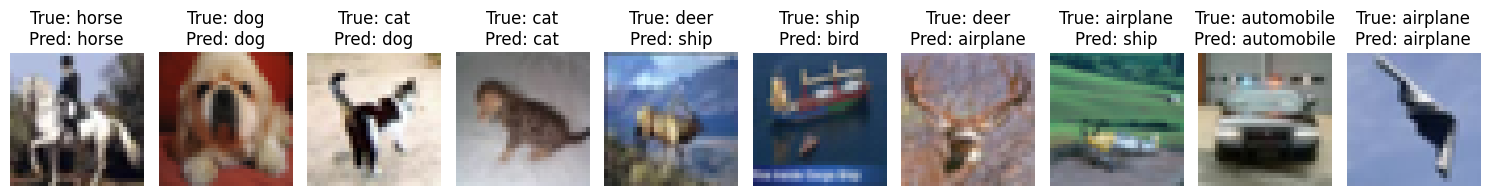

In [40]:
class_labels = [
    "airplane", "automobile", "bird", "cat", "deer",
    "dog", "frog", "horse", "ship", "truck"
]

model = TowerViT(image_size, patch_size, in_channels, embed_dim, n_heads, hidden_dim, num_transformers, num_classes)
PATH = "saved_models/towervit/model_20250309_025004_198"
model.load_state_dict(torch.load(PATH, weights_only=True))
model = model.to(device)

test_and_display_random_images(model, testset, num_images=10, class_labels=class_labels, device=device)

In [27]:
image_size = 32
patch_size = 4
in_channels = 3

in_embed_dims = [64, 128, 256]  
out_embed_dims = [128, 256, 256]
num_heads = [4, 8, 16]
hidden_dims = [128, 256, 512]
num_transformers = 3
num_classes = 10

vit = ViT(image_size, patch_size, in_channels, in_embed_dims, out_embed_dims, num_heads, hidden_dims, num_transformers, num_classes)

x = torch.randn(1, 3, 32, 32)
output = vit(x)
print(output.shape)

torch.Size([1, 10])


In [24]:
print(summary(vit, (1, in_channels, image_size, image_size)))

Layer (type:depth-idx)                   Output Shape              Param #
ViT                                      [1, 10]                   4,194,432
├─PatchEmbedding: 1-1                    [1, 64, 64]               --
│    └─Conv2d: 2-1                       [1, 64, 8, 8]             3,136
├─ModuleList: 1-2                        --                        --
│    └─Transformer: 2-2                  [1, 65, 64]               --
│    │    └─MultiheadAttention: 3-1      [1, 65, 64]               16,640
│    │    └─LayerNorm: 3-2               [1, 65, 64]               128
│    │    └─FeedForward: 3-3             [1, 65, 64]               16,576
│    │    └─LayerNorm: 3-4               [1, 65, 64]               128
│    └─Linear: 2-3                       [1, 65, 128]              8,320
│    └─Transformer: 2-4                  [1, 65, 128]              --
│    │    └─MultiheadAttention: 3-5      [1, 65, 128]              66,048
│    │    └─LayerNorm: 3-6               [1, 65, 128]     

In [28]:
BATCH_SIZE = 128
epochs = 200
learning_rate = 3e-4

vit = vit.to(device)

#using the same optimizer as in the ViT paper
opt = torch.optim.SGD(vit.parameters(), lr=learning_rate, momentum=0.9)
criterion = nn.CrossEntropyLoss()

train_loader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True, pin_memory=True)
test_loader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE, pin_memory=True)

timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
writer = SummaryWriter('runs/VIT_trainer_validation_{}'.format(timestamp))
training_and_validation_loop(vit, train_loader, test_loader, epochs, writer, device, opt, timestamp, flatten=False)

Epoch 1


Training: 100%|██████████| 391/391 [00:08<00:00, 48.17it/s]


Correct: 1786, Total: 10000, Accuracy: 0.18
Accuracy: 17.86% (0.1786)
Loss: 2.282126602373625


Validation: 100%|██████████| 79/79 [00:01<00:00, 78.43it/s]


LOSS train 2.282126602373625 valid 2.2489116191864014
Saving model
Epoch 2


Training: 100%|██████████| 391/391 [00:07<00:00, 50.62it/s]


Correct: 2225, Total: 10000, Accuracy: 0.22
Accuracy: 22.25% (0.2225)
Loss: 2.155605102840223


Validation: 100%|██████████| 79/79 [00:01<00:00, 78.97it/s]


LOSS train 2.155605102840223 valid 2.107799530029297
Saving model
Epoch 3


Training: 100%|██████████| 391/391 [00:07<00:00, 50.69it/s]


Correct: 2477, Total: 10000, Accuracy: 0.25
Accuracy: 24.77% (0.2477)
Loss: 2.025271258856121


Validation: 100%|██████████| 79/79 [00:01<00:00, 78.90it/s]


LOSS train 2.025271258856121 valid 1.987391471862793
Saving model
Epoch 4


Training: 100%|██████████| 391/391 [00:07<00:00, 50.48it/s]


Correct: 2679, Total: 10000, Accuracy: 0.27
Accuracy: 26.790000000000003% (0.2679)
Loss: 1.9706587101283826


Validation: 100%|██████████| 79/79 [00:00<00:00, 79.50it/s]


LOSS train 1.9706587101283826 valid 1.9408842325210571
Saving model
Epoch 5


Training: 100%|██████████| 391/391 [00:07<00:00, 50.70it/s]


Correct: 2840, Total: 10000, Accuracy: 0.28
Accuracy: 28.4% (0.284)
Loss: 1.947525984362552


Validation: 100%|██████████| 79/79 [00:01<00:00, 78.84it/s]


LOSS train 1.947525984362552 valid 1.9094053506851196
Saving model
Epoch 6


Training: 100%|██████████| 391/391 [00:07<00:00, 50.87it/s]


Correct: 2921, Total: 10000, Accuracy: 0.29
Accuracy: 29.21% (0.2921)
Loss: 1.9556463454899036


Validation: 100%|██████████| 79/79 [00:00<00:00, 79.40it/s]


LOSS train 1.9556463454899036 valid 1.882969856262207
Epoch 7


Training: 100%|██████████| 391/391 [00:07<00:00, 50.64it/s]


Correct: 2999, Total: 10000, Accuracy: 0.30
Accuracy: 29.99% (0.2999)
Loss: 1.8775088787078857


Validation: 100%|██████████| 79/79 [00:00<00:00, 79.15it/s]


LOSS train 1.8775088787078857 valid 1.8631168603897095
Saving model
Epoch 8


Training: 100%|██████████| 391/391 [00:07<00:00, 50.74it/s]


Correct: 3060, Total: 10000, Accuracy: 0.31
Accuracy: 30.599999999999998% (0.306)
Loss: 1.8722521003923918


Validation: 100%|██████████| 79/79 [00:00<00:00, 79.90it/s]


LOSS train 1.8722521003923918 valid 1.8502463102340698
Saving model
Epoch 9


Training: 100%|██████████| 391/391 [00:07<00:00, 50.62it/s]


Correct: 3100, Total: 10000, Accuracy: 0.31
Accuracy: 31.0% (0.31)
Loss: 1.8370696996387683


Validation: 100%|██████████| 79/79 [00:00<00:00, 79.23it/s]


LOSS train 1.8370696996387683 valid 1.8376381397247314
Saving model
Epoch 10


Training: 100%|██████████| 391/391 [00:07<00:00, 50.64it/s]


Correct: 3141, Total: 10000, Accuracy: 0.31
Accuracy: 31.41% (0.3141)
Loss: 1.873523241595218


Validation: 100%|██████████| 79/79 [00:00<00:00, 79.03it/s]


LOSS train 1.873523241595218 valid 1.8271912336349487
Epoch 11


Training: 100%|██████████| 391/391 [00:07<00:00, 50.80it/s]


Correct: 3228, Total: 10000, Accuracy: 0.32
Accuracy: 32.28% (0.3228)
Loss: 1.8418188032351042


Validation: 100%|██████████| 79/79 [00:01<00:00, 78.93it/s]


LOSS train 1.8418188032351042 valid 1.8132168054580688
Epoch 12


Training: 100%|██████████| 391/391 [00:07<00:00, 50.67it/s]


Correct: 3216, Total: 10000, Accuracy: 0.32
Accuracy: 32.16% (0.3216)
Loss: 1.8835677535910356


Validation: 100%|██████████| 79/79 [00:00<00:00, 79.14it/s]


LOSS train 1.8835677535910356 valid 1.8022358417510986
Epoch 13


Training: 100%|██████████| 391/391 [00:07<00:00, 50.59it/s]


Correct: 3259, Total: 10000, Accuracy: 0.33
Accuracy: 32.59% (0.3259)
Loss: 1.8452723841918142


Validation: 100%|██████████| 79/79 [00:00<00:00, 79.20it/s]


LOSS train 1.8452723841918142 valid 1.7907522916793823
Epoch 14


Training: 100%|██████████| 391/391 [00:07<00:00, 50.52it/s]


Correct: 3468, Total: 10000, Accuracy: 0.35
Accuracy: 34.68% (0.3468)
Loss: 1.8159169021405672


Validation: 100%|██████████| 79/79 [00:01<00:00, 79.00it/s]


LOSS train 1.8159169021405672 valid 1.7564871311187744
Saving model
Epoch 15


Training: 100%|██████████| 391/391 [00:07<00:00, 50.50it/s]


Correct: 3515, Total: 10000, Accuracy: 0.35
Accuracy: 35.15% (0.3515)
Loss: 1.7447967717522068


Validation: 100%|██████████| 79/79 [00:00<00:00, 79.09it/s]


LOSS train 1.7447967717522068 valid 1.7411415576934814
Saving model
Epoch 16


Training: 100%|██████████| 391/391 [00:07<00:00, 50.43it/s]


Correct: 3557, Total: 10000, Accuracy: 0.36
Accuracy: 35.57% (0.3557)
Loss: 1.7284429136075472


Validation: 100%|██████████| 79/79 [00:00<00:00, 79.09it/s]


LOSS train 1.7284429136075472 valid 1.7157262563705444
Saving model
Epoch 17


Training: 100%|██████████| 391/391 [00:07<00:00, 50.86it/s]


Correct: 3721, Total: 10000, Accuracy: 0.37
Accuracy: 37.21% (0.3721)
Loss: 1.7079546137859947


Validation: 100%|██████████| 79/79 [00:00<00:00, 79.60it/s]


LOSS train 1.7079546137859947 valid 1.6813029050827026
Saving model
Epoch 18


Training: 100%|██████████| 391/391 [00:07<00:00, 50.83it/s]


Correct: 3504, Total: 10000, Accuracy: 0.35
Accuracy: 35.04% (0.3504)
Loss: 1.709153558078565


Validation: 100%|██████████| 79/79 [00:01<00:00, 78.92it/s]


LOSS train 1.709153558078565 valid 1.7057430744171143
Epoch 19


Training: 100%|██████████| 391/391 [00:07<00:00, 51.05it/s]


Correct: 3782, Total: 10000, Accuracy: 0.38
Accuracy: 37.82% (0.3782)
Loss: 1.6858327388763428


Validation: 100%|██████████| 79/79 [00:00<00:00, 79.12it/s]


LOSS train 1.6858327388763428 valid 1.6608924865722656
Saving model
Epoch 20


Training: 100%|██████████| 391/391 [00:07<00:00, 50.95it/s]


Correct: 3790, Total: 10000, Accuracy: 0.38
Accuracy: 37.9% (0.379)
Loss: 1.6638242696460925


Validation: 100%|██████████| 79/79 [00:00<00:00, 79.25it/s]


LOSS train 1.6638242696460925 valid 1.6534537076950073
Saving model
Epoch 21


Training: 100%|██████████| 391/391 [00:07<00:00, 51.01it/s]


Correct: 3804, Total: 10000, Accuracy: 0.38
Accuracy: 38.04% (0.3804)
Loss: 1.633581280708313


Validation: 100%|██████████| 79/79 [00:00<00:00, 79.09it/s]


LOSS train 1.633581280708313 valid 1.663529396057129
Saving model
Epoch 22


Training: 100%|██████████| 391/391 [00:07<00:00, 50.75it/s]


Correct: 3943, Total: 10000, Accuracy: 0.39
Accuracy: 39.43% (0.3943)
Loss: 1.6512636573691117


Validation: 100%|██████████| 79/79 [00:00<00:00, 79.37it/s]


LOSS train 1.6512636573691117 valid 1.6282376050949097
Epoch 23


Training: 100%|██████████| 391/391 [00:07<00:00, 50.97it/s]


Correct: 4020, Total: 10000, Accuracy: 0.40
Accuracy: 40.2% (0.402)
Loss: 1.609141180389806


Validation: 100%|██████████| 79/79 [00:01<00:00, 78.80it/s]


LOSS train 1.609141180389806 valid 1.5951818227767944
Saving model
Epoch 24


Training: 100%|██████████| 391/391 [00:07<00:00, 50.84it/s]


Correct: 4085, Total: 10000, Accuracy: 0.41
Accuracy: 40.849999999999994% (0.4085)
Loss: 1.6045851707458496


Validation: 100%|██████████| 79/79 [00:00<00:00, 79.39it/s]


LOSS train 1.6045851707458496 valid 1.595910906791687
Saving model
Epoch 25


Training: 100%|██████████| 391/391 [00:07<00:00, 51.10it/s]


Correct: 4198, Total: 10000, Accuracy: 0.42
Accuracy: 41.980000000000004% (0.4198)
Loss: 1.587801782708419


Validation: 100%|██████████| 79/79 [00:00<00:00, 79.95it/s]


LOSS train 1.587801782708419 valid 1.5724204778671265
Saving model
Epoch 26


Training: 100%|██████████| 391/391 [00:07<00:00, 51.05it/s]


Correct: 4120, Total: 10000, Accuracy: 0.41
Accuracy: 41.199999999999996% (0.412)
Loss: 1.5868752065457796


Validation: 100%|██████████| 79/79 [00:00<00:00, 79.47it/s]


LOSS train 1.5868752065457796 valid 1.578286051750183
Saving model
Epoch 27


Training: 100%|██████████| 391/391 [00:07<00:00, 51.06it/s]


Correct: 4350, Total: 10000, Accuracy: 0.43
Accuracy: 43.5% (0.435)
Loss: 1.5584463194796914


Validation: 100%|██████████| 79/79 [00:00<00:00, 80.02it/s]


LOSS train 1.5584463194796914 valid 1.5359783172607422
Saving model
Epoch 28


Training: 100%|██████████| 391/391 [00:07<00:00, 51.01it/s]


Correct: 4411, Total: 10000, Accuracy: 0.44
Accuracy: 44.11% (0.4411)
Loss: 1.577422857284546


Validation: 100%|██████████| 79/79 [00:00<00:00, 79.81it/s]


LOSS train 1.577422857284546 valid 1.525771975517273
Epoch 29


Training: 100%|██████████| 391/391 [00:07<00:00, 51.18it/s]


Correct: 4340, Total: 10000, Accuracy: 0.43
Accuracy: 43.4% (0.434)
Loss: 1.5644577867106388


Validation: 100%|██████████| 79/79 [00:00<00:00, 79.41it/s]


LOSS train 1.5644577867106388 valid 1.5414080619812012
Epoch 30


Training: 100%|██████████| 391/391 [00:07<00:00, 51.09it/s]


Correct: 4426, Total: 10000, Accuracy: 0.44
Accuracy: 44.26% (0.4426)
Loss: 1.5455566205476459


Validation: 100%|██████████| 79/79 [00:00<00:00, 79.89it/s]


LOSS train 1.5455566205476459 valid 1.5115588903427124
Saving model
Epoch 31


Training: 100%|██████████| 391/391 [00:07<00:00, 51.25it/s]


Correct: 4567, Total: 10000, Accuracy: 0.46
Accuracy: 45.67% (0.4567)
Loss: 1.5262330770492554


Validation: 100%|██████████| 79/79 [00:00<00:00, 80.14it/s]


LOSS train 1.5262330770492554 valid 1.4828009605407715
Saving model
Epoch 32


Training: 100%|██████████| 391/391 [00:07<00:00, 50.94it/s]


Correct: 4268, Total: 10000, Accuracy: 0.43
Accuracy: 42.68% (0.4268)
Loss: 1.5111610889434814


Validation: 100%|██████████| 79/79 [00:00<00:00, 79.78it/s]


LOSS train 1.5111610889434814 valid 1.5400241613388062
Saving model
Epoch 33


Training: 100%|██████████| 391/391 [00:07<00:00, 51.11it/s]


Correct: 4215, Total: 10000, Accuracy: 0.42
Accuracy: 42.15% (0.4215)
Loss: 1.4976763850764225


Validation: 100%|██████████| 79/79 [00:00<00:00, 79.66it/s]


LOSS train 1.4976763850764225 valid 1.5648722648620605
Saving model
Epoch 34


Training: 100%|██████████| 391/391 [00:07<00:00, 51.24it/s]


Correct: 4559, Total: 10000, Accuracy: 0.46
Accuracy: 45.59% (0.4559)
Loss: 1.4720181665922467


Validation: 100%|██████████| 79/79 [00:00<00:00, 79.91it/s]


LOSS train 1.4720181665922467 valid 1.4842127561569214
Saving model
Epoch 35


Training: 100%|██████████| 391/391 [00:07<00:00, 51.08it/s]


Correct: 4678, Total: 10000, Accuracy: 0.47
Accuracy: 46.78% (0.4678)
Loss: 1.45500774132578


Validation: 100%|██████████| 79/79 [00:00<00:00, 79.90it/s]


LOSS train 1.45500774132578 valid 1.4491347074508667
Saving model
Epoch 36


Training: 100%|██████████| 391/391 [00:07<00:00, 51.18it/s]


Correct: 4514, Total: 10000, Accuracy: 0.45
Accuracy: 45.14% (0.4514)
Loss: 1.4188803559855412


Validation: 100%|██████████| 79/79 [00:00<00:00, 79.98it/s]


LOSS train 1.4188803559855412 valid 1.497489094734192
Saving model
Epoch 37


Training: 100%|██████████| 391/391 [00:07<00:00, 51.01it/s]


Correct: 4776, Total: 10000, Accuracy: 0.48
Accuracy: 47.760000000000005% (0.4776)
Loss: 1.44752121599097


Validation: 100%|██████████| 79/79 [00:00<00:00, 79.40it/s]


LOSS train 1.44752121599097 valid 1.4225982427597046
Epoch 38


Training: 100%|██████████| 391/391 [00:07<00:00, 51.00it/s]


Correct: 4818, Total: 10000, Accuracy: 0.48
Accuracy: 48.18% (0.4818)
Loss: 1.4632385279002942


Validation: 100%|██████████| 79/79 [00:00<00:00, 79.05it/s]


LOSS train 1.4632385279002942 valid 1.4157460927963257
Epoch 39


Training: 100%|██████████| 391/391 [00:07<00:00, 51.07it/s]


Correct: 4799, Total: 10000, Accuracy: 0.48
Accuracy: 47.99% (0.4799)
Loss: 1.4506837192334627


Validation: 100%|██████████| 79/79 [00:00<00:00, 79.35it/s]


LOSS train 1.4506837192334627 valid 1.4076905250549316
Epoch 40


Training: 100%|██████████| 391/391 [00:07<00:00, 50.83it/s]


Correct: 4904, Total: 10000, Accuracy: 0.49
Accuracy: 49.04% (0.4904)
Loss: 1.3945442814576


Validation: 100%|██████████| 79/79 [00:01<00:00, 78.97it/s]


LOSS train 1.3945442814576 valid 1.3979549407958984
Saving model
Epoch 41


Training: 100%|██████████| 391/391 [00:07<00:00, 50.74it/s]


Correct: 4889, Total: 10000, Accuracy: 0.49
Accuracy: 48.89% (0.4889)
Loss: 1.3636651039123535


Validation: 100%|██████████| 79/79 [00:00<00:00, 79.47it/s]


LOSS train 1.3636651039123535 valid 1.4022650718688965
Saving model
Epoch 42


Training: 100%|██████████| 391/391 [00:07<00:00, 51.11it/s]


Correct: 4992, Total: 10000, Accuracy: 0.50
Accuracy: 49.919999999999995% (0.4992)
Loss: 1.3912799672076577


Validation: 100%|██████████| 79/79 [00:00<00:00, 79.50it/s]


LOSS train 1.3912799672076577 valid 1.3726345300674438
Epoch 43


Training: 100%|██████████| 391/391 [00:07<00:00, 51.06it/s]


Correct: 4982, Total: 10000, Accuracy: 0.50
Accuracy: 49.82% (0.4982)
Loss: 1.3779240532925254


Validation: 100%|██████████| 79/79 [00:00<00:00, 79.41it/s]


LOSS train 1.3779240532925254 valid 1.3682526350021362
Epoch 44


Training: 100%|██████████| 391/391 [00:07<00:00, 51.04it/s]


Correct: 5093, Total: 10000, Accuracy: 0.51
Accuracy: 50.93% (0.5093)
Loss: 1.3405007751364457


Validation: 100%|██████████| 79/79 [00:00<00:00, 79.45it/s]


LOSS train 1.3405007751364457 valid 1.3511698246002197
Saving model
Epoch 45


Training: 100%|██████████| 391/391 [00:07<00:00, 50.96it/s]


Correct: 5024, Total: 10000, Accuracy: 0.50
Accuracy: 50.239999999999995% (0.5024)
Loss: 1.3313048325086896


Validation: 100%|██████████| 79/79 [00:00<00:00, 79.52it/s]


LOSS train 1.3313048325086896 valid 1.351404070854187
Saving model
Epoch 46


Training: 100%|██████████| 391/391 [00:07<00:00, 51.05it/s]


Correct: 5122, Total: 10000, Accuracy: 0.51
Accuracy: 51.22% (0.5122)
Loss: 1.3354293986370689


Validation: 100%|██████████| 79/79 [00:00<00:00, 79.68it/s]


LOSS train 1.3354293986370689 valid 1.3389443159103394
Epoch 47


Training: 100%|██████████| 391/391 [00:07<00:00, 51.01it/s]


Correct: 5063, Total: 10000, Accuracy: 0.51
Accuracy: 50.629999999999995% (0.5063)
Loss: 1.3160494503222013


Validation: 100%|██████████| 79/79 [00:00<00:00, 79.37it/s]


LOSS train 1.3160494503222013 valid 1.3475477695465088
Saving model
Epoch 48


Training: 100%|██████████| 391/391 [00:07<00:00, 50.93it/s]


Correct: 4983, Total: 10000, Accuracy: 0.50
Accuracy: 49.830000000000005% (0.4983)
Loss: 1.3178177758267051


Validation: 100%|██████████| 79/79 [00:00<00:00, 79.18it/s]


LOSS train 1.3178177758267051 valid 1.3681195974349976
Epoch 49


Training: 100%|██████████| 391/391 [00:07<00:00, 51.11it/s]


Correct: 5174, Total: 10000, Accuracy: 0.52
Accuracy: 51.739999999999995% (0.5174)
Loss: 1.3156404934431378


Validation: 100%|██████████| 79/79 [00:00<00:00, 79.12it/s]


LOSS train 1.3156404934431378 valid 1.3268150091171265
Saving model
Epoch 50


Training: 100%|██████████| 391/391 [00:07<00:00, 50.87it/s]


Correct: 5048, Total: 10000, Accuracy: 0.50
Accuracy: 50.480000000000004% (0.5048)
Loss: 1.312720863442672


Validation: 100%|██████████| 79/79 [00:00<00:00, 79.52it/s]


LOSS train 1.312720863442672 valid 1.3423670530319214
Saving model
Epoch 51


Training: 100%|██████████| 391/391 [00:07<00:00, 51.02it/s]


Correct: 5219, Total: 10000, Accuracy: 0.52
Accuracy: 52.190000000000005% (0.5219)
Loss: 1.3274203601636385


Validation: 100%|██████████| 79/79 [00:00<00:00, 80.02it/s]


LOSS train 1.3274203601636385 valid 1.3148760795593262
Epoch 52


Training: 100%|██████████| 391/391 [00:07<00:00, 51.22it/s]


Correct: 5143, Total: 10000, Accuracy: 0.51
Accuracy: 51.43% (0.5143)
Loss: 1.301486473334463


Validation: 100%|██████████| 79/79 [00:00<00:00, 79.44it/s]


LOSS train 1.301486473334463 valid 1.3207738399505615
Saving model
Epoch 53


Training: 100%|██████████| 391/391 [00:07<00:00, 50.74it/s]


Correct: 5234, Total: 10000, Accuracy: 0.52
Accuracy: 52.339999999999996% (0.5234)
Loss: 1.313163205196983


Validation: 100%|██████████| 79/79 [00:00<00:00, 79.51it/s]


LOSS train 1.313163205196983 valid 1.3065083026885986
Epoch 54


Training: 100%|██████████| 391/391 [00:07<00:00, 51.05it/s]


Correct: 5222, Total: 10000, Accuracy: 0.52
Accuracy: 52.22% (0.5222)
Loss: 1.3500178487677323


Validation: 100%|██████████| 79/79 [00:00<00:00, 79.26it/s]


LOSS train 1.3500178487677323 valid 1.3123449087142944
Epoch 55


Training: 100%|██████████| 391/391 [00:07<00:00, 51.06it/s]


Correct: 5285, Total: 10000, Accuracy: 0.53
Accuracy: 52.849999999999994% (0.5285)
Loss: 1.3006831344805265


Validation: 100%|██████████| 79/79 [00:00<00:00, 79.47it/s]


LOSS train 1.3006831344805265 valid 1.3034238815307617
Saving model
Epoch 56


Training: 100%|██████████| 391/391 [00:07<00:00, 51.20it/s]


Correct: 5267, Total: 10000, Accuracy: 0.53
Accuracy: 52.669999999999995% (0.5267)
Loss: 1.305646162284048


Validation: 100%|██████████| 79/79 [00:00<00:00, 80.44it/s]


LOSS train 1.305646162284048 valid 1.3093149662017822
Epoch 57


Training: 100%|██████████| 391/391 [00:07<00:00, 51.21it/s]


Correct: 5204, Total: 10000, Accuracy: 0.52
Accuracy: 52.04% (0.5204)
Loss: 1.271410214273553


Validation: 100%|██████████| 79/79 [00:00<00:00, 80.19it/s]


LOSS train 1.271410214273553 valid 1.3147066831588745
Saving model
Epoch 58


Training: 100%|██████████| 391/391 [00:07<00:00, 51.27it/s]


Correct: 5264, Total: 10000, Accuracy: 0.53
Accuracy: 52.64% (0.5264)
Loss: 1.260903935683401


Validation: 100%|██████████| 79/79 [00:00<00:00, 79.66it/s]


LOSS train 1.260903935683401 valid 1.2976245880126953
Saving model
Epoch 59


Training: 100%|██████████| 391/391 [00:07<00:00, 51.33it/s]


Correct: 5307, Total: 10000, Accuracy: 0.53
Accuracy: 53.06999999999999% (0.5307)
Loss: 1.2517523138146651


Validation: 100%|██████████| 79/79 [00:00<00:00, 79.61it/s]


LOSS train 1.2517523138146651 valid 1.3060096502304077
Saving model
Epoch 60


Training: 100%|██████████| 391/391 [00:07<00:00, 51.32it/s]


Correct: 5399, Total: 10000, Accuracy: 0.54
Accuracy: 53.99% (0.5399)
Loss: 1.269661219496476


Validation: 100%|██████████| 79/79 [00:00<00:00, 80.51it/s]


LOSS train 1.269661219496476 valid 1.2787309885025024
Epoch 61


Training: 100%|██████████| 391/391 [00:07<00:00, 51.23it/s]


Correct: 5292, Total: 10000, Accuracy: 0.53
Accuracy: 52.92% (0.5292)
Loss: 1.2739173989546926


Validation: 100%|██████████| 79/79 [00:00<00:00, 80.00it/s]


LOSS train 1.2739173989546926 valid 1.3011059761047363
Epoch 62


Training: 100%|██████████| 391/391 [00:07<00:00, 51.19it/s]


Correct: 5306, Total: 10000, Accuracy: 0.53
Accuracy: 53.059999999999995% (0.5306)
Loss: 1.2526230121913708


Validation: 100%|██████████| 79/79 [00:00<00:00, 80.06it/s]


LOSS train 1.2526230121913708 valid 1.293334722518921
Epoch 63


Training: 100%|██████████| 391/391 [00:07<00:00, 51.29it/s]


Correct: 5373, Total: 10000, Accuracy: 0.54
Accuracy: 53.73% (0.5373)
Loss: 1.223172614448949


Validation: 100%|██████████| 79/79 [00:00<00:00, 80.39it/s]


LOSS train 1.223172614448949 valid 1.2925677299499512
Saving model
Epoch 64


Training: 100%|██████████| 391/391 [00:07<00:00, 51.27it/s]


Correct: 5433, Total: 10000, Accuracy: 0.54
Accuracy: 54.33% (0.5433)
Loss: 1.257297346466466


Validation: 100%|██████████| 79/79 [00:00<00:00, 80.09it/s]


LOSS train 1.257297346466466 valid 1.2764722108840942
Epoch 65


Training: 100%|██████████| 391/391 [00:07<00:00, 51.20it/s]


Correct: 5393, Total: 10000, Accuracy: 0.54
Accuracy: 53.93% (0.5393)
Loss: 1.2282600089123374


Validation: 100%|██████████| 79/79 [00:00<00:00, 79.07it/s]


LOSS train 1.2282600089123374 valid 1.2850215435028076
Epoch 66


Training: 100%|██████████| 391/391 [00:07<00:00, 50.96it/s]


Correct: 5428, Total: 10000, Accuracy: 0.54
Accuracy: 54.279999999999994% (0.5428)
Loss: 1.209636311782034


Validation: 100%|██████████| 79/79 [00:00<00:00, 79.82it/s]


LOSS train 1.209636311782034 valid 1.2669193744659424
Saving model
Epoch 67


Training: 100%|██████████| 391/391 [00:07<00:00, 51.28it/s]


Correct: 5352, Total: 10000, Accuracy: 0.54
Accuracy: 53.52% (0.5352)
Loss: 1.2144173195487575


Validation: 100%|██████████| 79/79 [00:00<00:00, 79.63it/s]


LOSS train 1.2144173195487575 valid 1.2728561162948608
Epoch 68


Training: 100%|██████████| 391/391 [00:07<00:00, 51.20it/s]


Correct: 5447, Total: 10000, Accuracy: 0.54
Accuracy: 54.47% (0.5447)
Loss: 1.2407277069593732


Validation: 100%|██████████| 79/79 [00:00<00:00, 79.53it/s]


LOSS train 1.2407277069593732 valid 1.257750391960144
Epoch 69


Training: 100%|██████████| 391/391 [00:07<00:00, 51.23it/s]


Correct: 5452, Total: 10000, Accuracy: 0.55
Accuracy: 54.52% (0.5452)
Loss: 1.2317774797740735


Validation: 100%|██████████| 79/79 [00:00<00:00, 79.92it/s]


LOSS train 1.2317774797740735 valid 1.270124912261963
Epoch 70


Training: 100%|██████████| 391/391 [00:07<00:00, 51.29it/s]


Correct: 5351, Total: 10000, Accuracy: 0.54
Accuracy: 53.510000000000005% (0.5351)
Loss: 1.2297694934041876


Validation: 100%|██████████| 79/79 [00:00<00:00, 79.36it/s]


LOSS train 1.2297694934041876 valid 1.2788243293762207
Epoch 71


Training: 100%|██████████| 391/391 [00:07<00:00, 51.37it/s]


Correct: 5443, Total: 10000, Accuracy: 0.54
Accuracy: 54.43% (0.5443)
Loss: 1.213098036615472


Validation: 100%|██████████| 79/79 [00:00<00:00, 80.68it/s]


LOSS train 1.213098036615472 valid 1.2506088018417358
Epoch 72


Training: 100%|██████████| 391/391 [00:07<00:00, 51.37it/s]


Correct: 5524, Total: 10000, Accuracy: 0.55
Accuracy: 55.24% (0.5524)
Loss: 1.2219052942175614


Validation: 100%|██████████| 79/79 [00:00<00:00, 79.90it/s]


LOSS train 1.2219052942175614 valid 1.2546007633209229
Epoch 73


Training: 100%|██████████| 391/391 [00:07<00:00, 51.28it/s]


Correct: 5564, Total: 10000, Accuracy: 0.56
Accuracy: 55.64% (0.5564)
Loss: 1.2355388653905768


Validation: 100%|██████████| 79/79 [00:00<00:00, 79.51it/s]


LOSS train 1.2355388653905768 valid 1.23507821559906
Epoch 74


Training: 100%|██████████| 391/391 [00:07<00:00, 51.31it/s]


Correct: 5463, Total: 10000, Accuracy: 0.55
Accuracy: 54.63% (0.5463)
Loss: 1.219510505073949


Validation: 100%|██████████| 79/79 [00:00<00:00, 79.57it/s]


LOSS train 1.219510505073949 valid 1.255995750427246
Epoch 75


Training: 100%|██████████| 391/391 [00:07<00:00, 51.34it/s]


Correct: 5453, Total: 10000, Accuracy: 0.55
Accuracy: 54.53% (0.5453)
Loss: 1.1980227357462834


Validation: 100%|██████████| 79/79 [00:00<00:00, 79.48it/s]


LOSS train 1.1980227357462834 valid 1.2613983154296875
Saving model
Epoch 76


Training: 100%|██████████| 391/391 [00:07<00:00, 51.25it/s]


Correct: 5545, Total: 10000, Accuracy: 0.55
Accuracy: 55.45% (0.5545)
Loss: 1.2102231728403192


Validation: 100%|██████████| 79/79 [00:00<00:00, 79.48it/s]


LOSS train 1.2102231728403192 valid 1.2400976419448853
Epoch 77


Training: 100%|██████████| 391/391 [00:07<00:00, 51.24it/s]


Correct: 5551, Total: 10000, Accuracy: 0.56
Accuracy: 55.510000000000005% (0.5551)
Loss: 1.2431647024656598


Validation: 100%|██████████| 79/79 [00:00<00:00, 79.34it/s]


LOSS train 1.2431647024656598 valid 1.228188395500183
Epoch 78


Training: 100%|██████████| 391/391 [00:07<00:00, 50.91it/s]


Correct: 5574, Total: 10000, Accuracy: 0.56
Accuracy: 55.74% (0.5574)
Loss: 1.2162408138576306


Validation: 100%|██████████| 79/79 [00:00<00:00, 79.55it/s]


LOSS train 1.2162408138576306 valid 1.2303248643875122
Epoch 79


Training: 100%|██████████| 391/391 [00:07<00:00, 51.20it/s]


Correct: 5561, Total: 10000, Accuracy: 0.56
Accuracy: 55.61000000000001% (0.5561)
Loss: 1.183986108554037


Validation: 100%|██████████| 79/79 [00:00<00:00, 79.31it/s]


LOSS train 1.183986108554037 valid 1.2258318662643433
Saving model
Epoch 80


Training: 100%|██████████| 391/391 [00:07<00:00, 51.20it/s]


Correct: 5626, Total: 10000, Accuracy: 0.56
Accuracy: 56.26% (0.5626)
Loss: 1.2165427992218418


Validation: 100%|██████████| 79/79 [00:00<00:00, 79.89it/s]


LOSS train 1.2165427992218418 valid 1.2220150232315063
Epoch 81


Training: 100%|██████████| 391/391 [00:07<00:00, 51.40it/s]


Correct: 5327, Total: 10000, Accuracy: 0.53
Accuracy: 53.269999999999996% (0.5327)
Loss: 1.1916741697411788


Validation: 100%|██████████| 79/79 [00:00<00:00, 79.57it/s]


LOSS train 1.1916741697411788 valid 1.2839828729629517
Epoch 82


Training: 100%|██████████| 391/391 [00:07<00:00, 51.37it/s]


Correct: 5556, Total: 10000, Accuracy: 0.56
Accuracy: 55.559999999999995% (0.5556)
Loss: 1.147325358892742


Validation: 100%|██████████| 79/79 [00:00<00:00, 79.68it/s]


LOSS train 1.147325358892742 valid 1.222133994102478
Saving model
Epoch 83


Training: 100%|██████████| 391/391 [00:07<00:00, 51.31it/s]


Correct: 5533, Total: 10000, Accuracy: 0.55
Accuracy: 55.33% (0.5533)
Loss: 1.1641278957065784


Validation: 100%|██████████| 79/79 [00:00<00:00, 79.78it/s]


LOSS train 1.1641278957065784 valid 1.2255510091781616
Epoch 84


Training: 100%|██████████| 391/391 [00:07<00:00, 51.27it/s]


Correct: 5603, Total: 10000, Accuracy: 0.56
Accuracy: 56.03% (0.5603)
Loss: 1.1485201841906498


Validation: 100%|██████████| 79/79 [00:00<00:00, 79.93it/s]


LOSS train 1.1485201841906498 valid 1.214659333229065
Epoch 85


Training: 100%|██████████| 391/391 [00:07<00:00, 51.27it/s]


Correct: 5512, Total: 10000, Accuracy: 0.55
Accuracy: 55.120000000000005% (0.5512)
Loss: 1.1953687981555337


Validation: 100%|██████████| 79/79 [00:00<00:00, 80.05it/s]


LOSS train 1.1953687981555337 valid 1.2348793745040894
Epoch 86


Training: 100%|██████████| 391/391 [00:07<00:00, 51.20it/s]


Correct: 5584, Total: 10000, Accuracy: 0.56
Accuracy: 55.84% (0.5584)
Loss: 1.1747212347231413


Validation: 100%|██████████| 79/79 [00:00<00:00, 79.60it/s]


LOSS train 1.1747212347231413 valid 1.2162731885910034
Epoch 87


Training: 100%|██████████| 391/391 [00:07<00:00, 51.16it/s]


Correct: 5640, Total: 10000, Accuracy: 0.56
Accuracy: 56.39999999999999% (0.564)
Loss: 1.136834276349921


Validation: 100%|██████████| 79/79 [00:00<00:00, 79.57it/s]


LOSS train 1.136834276349921 valid 1.218386173248291
Saving model
Epoch 88


Training: 100%|██████████| 391/391 [00:07<00:00, 51.14it/s]


Correct: 5647, Total: 10000, Accuracy: 0.56
Accuracy: 56.47% (0.5647)
Loss: 1.1476455111252635


Validation: 100%|██████████| 79/79 [00:00<00:00, 79.56it/s]


LOSS train 1.1476455111252635 valid 1.2042317390441895
Epoch 89


Training: 100%|██████████| 391/391 [00:07<00:00, 51.10it/s]


Correct: 5633, Total: 10000, Accuracy: 0.56
Accuracy: 56.330000000000005% (0.5633)
Loss: 1.1885333563152112


Validation: 100%|██████████| 79/79 [00:00<00:00, 79.61it/s]


LOSS train 1.1885333563152112 valid 1.2047498226165771
Epoch 90


Training: 100%|██████████| 391/391 [00:07<00:00, 51.17it/s]


Correct: 5534, Total: 10000, Accuracy: 0.55
Accuracy: 55.34% (0.5534)
Loss: 1.1868865991893567


Validation: 100%|██████████| 79/79 [00:00<00:00, 79.51it/s]


LOSS train 1.1868865991893567 valid 1.2309235334396362
Epoch 91


Training: 100%|██████████| 391/391 [00:07<00:00, 51.20it/s]


Correct: 5482, Total: 10000, Accuracy: 0.55
Accuracy: 54.82% (0.5482)
Loss: 1.1356490223031295


Validation: 100%|██████████| 79/79 [00:00<00:00, 79.84it/s]


LOSS train 1.1356490223031295 valid 1.2346314191818237
Saving model
Epoch 92


Training: 100%|██████████| 391/391 [00:07<00:00, 51.28it/s]


Correct: 5621, Total: 10000, Accuracy: 0.56
Accuracy: 56.21000000000001% (0.5621)
Loss: 1.1670472966997247


Validation: 100%|██████████| 79/79 [00:00<00:00, 79.72it/s]


LOSS train 1.1670472966997247 valid 1.2171400785446167
Epoch 93


Training: 100%|██████████| 391/391 [00:07<00:00, 51.21it/s]


Correct: 5588, Total: 10000, Accuracy: 0.56
Accuracy: 55.879999999999995% (0.5588)
Loss: 1.2038687906767194


Validation: 100%|██████████| 79/79 [00:00<00:00, 80.10it/s]


LOSS train 1.2038687906767194 valid 1.2247999906539917
Epoch 94


Training: 100%|██████████| 391/391 [00:07<00:00, 51.21it/s]


Correct: 5688, Total: 10000, Accuracy: 0.57
Accuracy: 56.879999999999995% (0.5688)
Loss: 1.1686017074083026


Validation: 100%|██████████| 79/79 [00:00<00:00, 79.98it/s]


LOSS train 1.1686017074083026 valid 1.193491816520691
Epoch 95


Training: 100%|██████████| 391/391 [00:07<00:00, 51.26it/s]


Correct: 5661, Total: 10000, Accuracy: 0.57
Accuracy: 56.61000000000001% (0.5661)
Loss: 1.1111680833916915


Validation: 100%|██████████| 79/79 [00:00<00:00, 80.52it/s]


LOSS train 1.1111680833916915 valid 1.1985348463058472
Saving model
Epoch 96


Training: 100%|██████████| 391/391 [00:07<00:00, 51.18it/s]


Correct: 5682, Total: 10000, Accuracy: 0.57
Accuracy: 56.82000000000001% (0.5682)
Loss: 1.097719016828035


Validation: 100%|██████████| 79/79 [00:00<00:00, 79.57it/s]


LOSS train 1.097719016828035 valid 1.1976017951965332
Saving model
Epoch 97


Training: 100%|██████████| 391/391 [00:07<00:00, 51.19it/s]


Correct: 5679, Total: 10000, Accuracy: 0.57
Accuracy: 56.79% (0.5679)
Loss: 1.1400085844491656


Validation: 100%|██████████| 79/79 [00:00<00:00, 79.56it/s]


LOSS train 1.1400085844491656 valid 1.186937689781189
Epoch 98


Training: 100%|██████████| 391/391 [00:07<00:00, 51.18it/s]


Correct: 5646, Total: 10000, Accuracy: 0.56
Accuracy: 56.46% (0.5646)
Loss: 1.1239297139017206


Validation: 100%|██████████| 79/79 [00:00<00:00, 79.52it/s]


LOSS train 1.1239297139017206 valid 1.2005822658538818
Epoch 99


Training: 100%|██████████| 391/391 [00:07<00:00, 51.12it/s]


Correct: 5727, Total: 10000, Accuracy: 0.57
Accuracy: 57.269999999999996% (0.5727)
Loss: 1.1157033945384778


Validation: 100%|██████████| 79/79 [00:00<00:00, 79.53it/s]


LOSS train 1.1157033945384778 valid 1.183122992515564
Epoch 100


Training: 100%|██████████| 391/391 [00:07<00:00, 51.28it/s]


Correct: 5706, Total: 10000, Accuracy: 0.57
Accuracy: 57.06% (0.5706)
Loss: 1.127531205352984


Validation: 100%|██████████| 79/79 [00:00<00:00, 79.94it/s]


LOSS train 1.127531205352984 valid 1.1898376941680908
Epoch 101


Training: 100%|██████████| 391/391 [00:07<00:00, 51.27it/s]


Correct: 5572, Total: 10000, Accuracy: 0.56
Accuracy: 55.720000000000006% (0.5572)
Loss: 1.1544651420492875


Validation: 100%|██████████| 79/79 [00:00<00:00, 79.74it/s]


LOSS train 1.1544651420492875 valid 1.2402218580245972
Epoch 102


Training: 100%|██████████| 391/391 [00:07<00:00, 51.18it/s]


Correct: 5685, Total: 10000, Accuracy: 0.57
Accuracy: 56.85% (0.5685)
Loss: 1.0946255106674998


Validation: 100%|██████████| 79/79 [00:00<00:00, 80.56it/s]


LOSS train 1.0946255106674998 valid 1.2012710571289062
Saving model
Epoch 103


Training: 100%|██████████| 391/391 [00:07<00:00, 50.89it/s]


Correct: 5620, Total: 10000, Accuracy: 0.56
Accuracy: 56.2% (0.562)
Loss: 1.1551089694625454


Validation: 100%|██████████| 79/79 [00:00<00:00, 79.68it/s]


LOSS train 1.1551089694625454 valid 1.1960954666137695
Epoch 104


Training: 100%|██████████| 391/391 [00:07<00:00, 51.22it/s]


Correct: 5728, Total: 10000, Accuracy: 0.57
Accuracy: 57.28% (0.5728)
Loss: 1.116439794239245


Validation: 100%|██████████| 79/79 [00:00<00:00, 79.82it/s]


LOSS train 1.116439794239245 valid 1.1794288158416748
Epoch 105


Training: 100%|██████████| 391/391 [00:07<00:00, 51.29it/s]


Correct: 5748, Total: 10000, Accuracy: 0.57
Accuracy: 57.48% (0.5748)
Loss: 1.143362321351704


Validation: 100%|██████████| 79/79 [00:00<00:00, 79.45it/s]


LOSS train 1.143362321351704 valid 1.1832648515701294
Epoch 106


Training: 100%|██████████| 391/391 [00:07<00:00, 51.22it/s]


Correct: 5759, Total: 10000, Accuracy: 0.58
Accuracy: 57.589999999999996% (0.5759)
Loss: 1.0948585805140043


Validation: 100%|██████████| 79/79 [00:00<00:00, 79.61it/s]


LOSS train 1.0948585805140043 valid 1.1775245666503906
Epoch 107


Training: 100%|██████████| 391/391 [00:07<00:00, 51.16it/s]


Correct: 5686, Total: 10000, Accuracy: 0.57
Accuracy: 56.86% (0.5686)
Loss: 1.0831742506278188


Validation: 100%|██████████| 79/79 [00:00<00:00, 79.68it/s]


LOSS train 1.0831742506278188 valid 1.1782602071762085
Saving model
Epoch 108


Training: 100%|██████████| 391/391 [00:07<00:00, 51.12it/s]


Correct: 5704, Total: 10000, Accuracy: 0.57
Accuracy: 57.04% (0.5704)
Loss: 1.1223768089946948


Validation: 100%|██████████| 79/79 [00:00<00:00, 79.73it/s]


LOSS train 1.1223768089946948 valid 1.1873480081558228
Epoch 109


Training: 100%|██████████| 391/391 [00:07<00:00, 51.25it/s]


Correct: 5687, Total: 10000, Accuracy: 0.57
Accuracy: 56.87% (0.5687)
Loss: 1.0701513478630467


Validation: 100%|██████████| 79/79 [00:00<00:00, 79.66it/s]


LOSS train 1.0701513478630467 valid 1.1795506477355957
Saving model
Epoch 110


Training: 100%|██████████| 391/391 [00:07<00:00, 51.11it/s]


Correct: 5680, Total: 10000, Accuracy: 0.57
Accuracy: 56.8% (0.568)
Loss: 1.0957767398733842


Validation: 100%|██████████| 79/79 [00:00<00:00, 79.63it/s]


LOSS train 1.0957767398733842 valid 1.1766529083251953
Epoch 111


Training: 100%|██████████| 391/391 [00:07<00:00, 50.90it/s]


Correct: 5709, Total: 10000, Accuracy: 0.57
Accuracy: 57.089999999999996% (0.5709)
Loss: 1.0978814049770957


Validation: 100%|██████████| 79/79 [00:00<00:00, 79.47it/s]


LOSS train 1.0978814049770957 valid 1.1754398345947266
Epoch 112


Training: 100%|██████████| 391/391 [00:07<00:00, 50.98it/s]


Correct: 5789, Total: 10000, Accuracy: 0.58
Accuracy: 57.89% (0.5789)
Loss: 1.0778869045408148


Validation: 100%|██████████| 79/79 [00:00<00:00, 79.67it/s]


LOSS train 1.0778869045408148 valid 1.1622825860977173
Epoch 113


Training: 100%|██████████| 391/391 [00:07<00:00, 51.23it/s]


Correct: 5766, Total: 10000, Accuracy: 0.58
Accuracy: 57.66% (0.5766)
Loss: 1.1121222941499007


Validation: 100%|██████████| 79/79 [00:00<00:00, 79.60it/s]


LOSS train 1.1121222941499007 valid 1.1651848554611206
Epoch 114


Training: 100%|██████████| 391/391 [00:07<00:00, 51.29it/s]


Correct: 5742, Total: 10000, Accuracy: 0.57
Accuracy: 57.42% (0.5742)
Loss: 1.1123863929196407


Validation: 100%|██████████| 79/79 [00:01<00:00, 78.23it/s]


LOSS train 1.1123863929196407 valid 1.1669434309005737
Epoch 115


Training: 100%|██████████| 391/391 [00:07<00:00, 50.86it/s]


Correct: 5772, Total: 10000, Accuracy: 0.58
Accuracy: 57.720000000000006% (0.5772)
Loss: 1.0962493482388949


Validation: 100%|██████████| 79/79 [00:00<00:00, 79.62it/s]


LOSS train 1.0962493482388949 valid 1.16801917552948
Epoch 116


Training: 100%|██████████| 391/391 [00:07<00:00, 51.14it/s]


Correct: 5701, Total: 10000, Accuracy: 0.57
Accuracy: 57.010000000000005% (0.5701)
Loss: 1.0797017153940702


Validation: 100%|██████████| 79/79 [00:00<00:00, 79.70it/s]


LOSS train 1.0797017153940702 valid 1.1774905920028687
Epoch 117


Training: 100%|██████████| 391/391 [00:07<00:00, 51.04it/s]


Correct: 5694, Total: 10000, Accuracy: 0.57
Accuracy: 56.940000000000005% (0.5694)
Loss: 1.0598096157375134


Validation: 100%|██████████| 79/79 [00:00<00:00, 79.57it/s]


LOSS train 1.0598096157375134 valid 1.1787323951721191
Saving model
Epoch 118


Training: 100%|██████████| 391/391 [00:07<00:00, 51.22it/s]


Correct: 5777, Total: 10000, Accuracy: 0.58
Accuracy: 57.769999999999996% (0.5777)
Loss: 1.1114819865477712


Validation: 100%|██████████| 79/79 [00:00<00:00, 79.64it/s]


LOSS train 1.1114819865477712 valid 1.1640539169311523
Epoch 119


Training: 100%|██████████| 391/391 [00:07<00:00, 51.18it/s]


Correct: 5793, Total: 10000, Accuracy: 0.58
Accuracy: 57.93000000000001% (0.5793)
Loss: 1.1113152786305076


Validation: 100%|██████████| 79/79 [00:00<00:00, 79.54it/s]


LOSS train 1.1113152786305076 valid 1.1696535348892212
Epoch 120


Training: 100%|██████████| 391/391 [00:07<00:00, 51.24it/s]


Correct: 5763, Total: 10000, Accuracy: 0.58
Accuracy: 57.63% (0.5763)
Loss: 1.0923289123334383


Validation: 100%|██████████| 79/79 [00:00<00:00, 79.74it/s]


LOSS train 1.0923289123334383 valid 1.166912317276001
Epoch 121


Training: 100%|██████████| 391/391 [00:07<00:00, 51.21it/s]


Correct: 5780, Total: 10000, Accuracy: 0.58
Accuracy: 57.8% (0.578)
Loss: 1.1090412767309892


Validation: 100%|██████████| 79/79 [00:00<00:00, 79.84it/s]


LOSS train 1.1090412767309892 valid 1.1512562036514282
Epoch 122


Training: 100%|██████████| 391/391 [00:07<00:00, 51.22it/s]


Correct: 5776, Total: 10000, Accuracy: 0.58
Accuracy: 57.76% (0.5776)
Loss: 1.0595309357894094


Validation: 100%|██████████| 79/79 [00:00<00:00, 79.76it/s]


LOSS train 1.0595309357894094 valid 1.1586331129074097
Saving model
Epoch 123


Training: 100%|██████████| 391/391 [00:07<00:00, 51.15it/s]


Correct: 5802, Total: 10000, Accuracy: 0.58
Accuracy: 58.02% (0.5802)
Loss: 1.111652512299387


Validation: 100%|██████████| 79/79 [00:00<00:00, 80.04it/s]


LOSS train 1.111652512299387 valid 1.1542047262191772
Epoch 124


Training: 100%|██████████| 391/391 [00:07<00:00, 51.08it/s]


Correct: 5794, Total: 10000, Accuracy: 0.58
Accuracy: 57.940000000000005% (0.5794)
Loss: 1.0683157820450633


Validation: 100%|██████████| 79/79 [00:00<00:00, 79.63it/s]


LOSS train 1.0683157820450633 valid 1.1532871723175049
Epoch 125


Training: 100%|██████████| 391/391 [00:07<00:00, 51.22it/s]


Correct: 5828, Total: 10000, Accuracy: 0.58
Accuracy: 58.28% (0.5828)
Loss: 1.0575177700896012


Validation: 100%|██████████| 79/79 [00:00<00:00, 79.53it/s]


LOSS train 1.0575177700896012 valid 1.1474288702011108
Saving model
Epoch 126


Training: 100%|██████████| 391/391 [00:07<00:00, 51.15it/s]


Correct: 5808, Total: 10000, Accuracy: 0.58
Accuracy: 58.08% (0.5808)
Loss: 1.0873231793704785


Validation: 100%|██████████| 79/79 [00:00<00:00, 79.62it/s]


LOSS train 1.0873231793704785 valid 1.1476318836212158
Epoch 127


Training: 100%|██████████| 391/391 [00:07<00:00, 51.13it/s]


Correct: 5779, Total: 10000, Accuracy: 0.58
Accuracy: 57.79% (0.5779)
Loss: 1.059438118809148


Validation: 100%|██████████| 79/79 [00:00<00:00, 79.36it/s]


LOSS train 1.059438118809148 valid 1.1540663242340088
Epoch 128


Training: 100%|██████████| 391/391 [00:07<00:00, 49.55it/s]


Correct: 5826, Total: 10000, Accuracy: 0.58
Accuracy: 58.26% (0.5826)
Loss: 1.065795427874515


Validation: 100%|██████████| 79/79 [00:00<00:00, 79.56it/s]


LOSS train 1.065795427874515 valid 1.1492623090744019
Epoch 129


Training: 100%|██████████| 391/391 [00:07<00:00, 51.19it/s]


Correct: 5753, Total: 10000, Accuracy: 0.58
Accuracy: 57.53% (0.5753)
Loss: 1.0437223785801937


Validation: 100%|██████████| 79/79 [00:00<00:00, 80.19it/s]


LOSS train 1.0437223785801937 valid 1.1567397117614746
Saving model
Epoch 130


Training: 100%|██████████| 391/391 [00:07<00:00, 51.23it/s]


Correct: 5772, Total: 10000, Accuracy: 0.58
Accuracy: 57.720000000000006% (0.5772)
Loss: 1.0800289103859348


Validation: 100%|██████████| 79/79 [00:00<00:00, 80.21it/s]


LOSS train 1.0800289103859348 valid 1.1454395055770874
Epoch 131


Training: 100%|██████████| 391/391 [00:07<00:00, 51.24it/s]


Correct: 5809, Total: 10000, Accuracy: 0.58
Accuracy: 58.089999999999996% (0.5809)
Loss: 1.062957719752663


Validation: 100%|██████████| 79/79 [00:00<00:00, 79.53it/s]


LOSS train 1.062957719752663 valid 1.147289752960205
Epoch 132


Training: 100%|██████████| 391/391 [00:07<00:00, 51.26it/s]


Correct: 5763, Total: 10000, Accuracy: 0.58
Accuracy: 57.63% (0.5763)
Loss: 1.0865001898062856


Validation: 100%|██████████| 79/79 [00:00<00:00, 79.30it/s]


LOSS train 1.0865001898062856 valid 1.1611465215682983
Epoch 133


Training: 100%|██████████| 391/391 [00:07<00:00, 51.19it/s]


Correct: 5859, Total: 10000, Accuracy: 0.59
Accuracy: 58.589999999999996% (0.5859)
Loss: 1.0939421496893231


Validation: 100%|██████████| 79/79 [00:00<00:00, 79.66it/s]


LOSS train 1.0939421496893231 valid 1.1388771533966064
Epoch 134


Training: 100%|██████████| 391/391 [00:07<00:00, 51.14it/s]


Correct: 5841, Total: 10000, Accuracy: 0.58
Accuracy: 58.41% (0.5841)
Loss: 1.0273309569609792


Validation: 100%|██████████| 79/79 [00:00<00:00, 79.85it/s]


LOSS train 1.0273309569609792 valid 1.1377164125442505
Saving model
Epoch 135


Training: 100%|██████████| 391/391 [00:07<00:00, 51.22it/s]


Correct: 5833, Total: 10000, Accuracy: 0.58
Accuracy: 58.330000000000005% (0.5833)
Loss: 1.0687414313617505


Validation: 100%|██████████| 79/79 [00:00<00:00, 79.85it/s]


LOSS train 1.0687414313617505 valid 1.1398643255233765
Epoch 136


Training: 100%|██████████| 391/391 [00:07<00:00, 51.22it/s]


Correct: 5900, Total: 10000, Accuracy: 0.59
Accuracy: 59.0% (0.59)
Loss: 1.0098676367809898


Validation: 100%|██████████| 79/79 [00:00<00:00, 80.47it/s]


LOSS train 1.0098676367809898 valid 1.1387039422988892
Saving model
Epoch 137


Training: 100%|██████████| 391/391 [00:07<00:00, 51.16it/s]


Correct: 5793, Total: 10000, Accuracy: 0.58
Accuracy: 57.93000000000001% (0.5793)
Loss: 1.0367735624313354


Validation: 100%|██████████| 79/79 [00:00<00:00, 80.20it/s]


LOSS train 1.0367735624313354 valid 1.141924262046814
Epoch 138


Training: 100%|██████████| 391/391 [00:07<00:00, 51.13it/s]


Correct: 5856, Total: 10000, Accuracy: 0.59
Accuracy: 58.56% (0.5856)
Loss: 1.0360189707655656


Validation: 100%|██████████| 79/79 [00:00<00:00, 79.57it/s]


LOSS train 1.0360189707655656 valid 1.141495943069458
Epoch 139


Training: 100%|██████████| 391/391 [00:07<00:00, 51.09it/s]


Correct: 5900, Total: 10000, Accuracy: 0.59
Accuracy: 59.0% (0.59)
Loss: 1.0662925243377686


Validation: 100%|██████████| 79/79 [00:00<00:00, 80.23it/s]


LOSS train 1.0662925243377686 valid 1.1303070783615112
Epoch 140


Training: 100%|██████████| 391/391 [00:07<00:00, 50.79it/s]


Correct: 5857, Total: 10000, Accuracy: 0.59
Accuracy: 58.57% (0.5857)
Loss: 1.0439115825452303


Validation: 100%|██████████| 79/79 [00:00<00:00, 80.30it/s]


LOSS train 1.0439115825452303 valid 1.1380558013916016
Epoch 141


Training: 100%|██████████| 391/391 [00:07<00:00, 51.12it/s]


Correct: 5899, Total: 10000, Accuracy: 0.59
Accuracy: 58.989999999999995% (0.5899)
Loss: 0.9925942640555533


Validation: 100%|██████████| 79/79 [00:00<00:00, 80.35it/s]


LOSS train 0.9925942640555533 valid 1.1307281255722046
Saving model
Epoch 142


Training: 100%|██████████| 391/391 [00:07<00:00, 51.25it/s]


Correct: 5847, Total: 10000, Accuracy: 0.58
Accuracy: 58.47% (0.5847)
Loss: 1.0624463966018276


Validation: 100%|██████████| 79/79 [00:00<00:00, 80.10it/s]


LOSS train 1.0624463966018276 valid 1.147273063659668
Epoch 143


Training: 100%|██████████| 391/391 [00:07<00:00, 51.26it/s]


Correct: 5904, Total: 10000, Accuracy: 0.59
Accuracy: 59.040000000000006% (0.5904)
Loss: 1.0231395897112394


Validation: 100%|██████████| 79/79 [00:00<00:00, 79.66it/s]


LOSS train 1.0231395897112394 valid 1.1330101490020752
Epoch 144


Training: 100%|██████████| 391/391 [00:07<00:00, 51.10it/s]


Correct: 5871, Total: 10000, Accuracy: 0.59
Accuracy: 58.709999999999994% (0.5871)
Loss: 1.0401755163544102


Validation: 100%|██████████| 79/79 [00:00<00:00, 79.15it/s]


LOSS train 1.0401755163544102 valid 1.1244436502456665
Epoch 145


Training: 100%|██████████| 391/391 [00:07<00:00, 51.09it/s]


Correct: 5901, Total: 10000, Accuracy: 0.59
Accuracy: 59.01% (0.5901)
Loss: 1.0040186863196523


Validation: 100%|██████████| 79/79 [00:00<00:00, 79.56it/s]


LOSS train 1.0040186863196523 valid 1.13532292842865
Epoch 146


Training: 100%|██████████| 391/391 [00:07<00:00, 51.07it/s]


Correct: 5907, Total: 10000, Accuracy: 0.59
Accuracy: 59.07% (0.5907)
Loss: 1.0572168168268705


Validation: 100%|██████████| 79/79 [00:00<00:00, 79.42it/s]


LOSS train 1.0572168168268705 valid 1.1308319568634033
Epoch 147


Training: 100%|██████████| 391/391 [00:07<00:00, 51.14it/s]


Correct: 5925, Total: 10000, Accuracy: 0.59
Accuracy: 59.25% (0.5925)
Loss: 1.0152200774142617


Validation: 100%|██████████| 79/79 [00:00<00:00, 79.54it/s]


LOSS train 1.0152200774142617 valid 1.1239687204360962
Epoch 148


Training: 100%|██████████| 391/391 [00:07<00:00, 50.94it/s]


Correct: 5908, Total: 10000, Accuracy: 0.59
Accuracy: 59.08% (0.5908)
Loss: 1.0185626400144476


Validation: 100%|██████████| 79/79 [00:00<00:00, 79.28it/s]


LOSS train 1.0185626400144476 valid 1.121559977531433
Epoch 149


Training: 100%|██████████| 391/391 [00:07<00:00, 50.91it/s]


Correct: 5914, Total: 10000, Accuracy: 0.59
Accuracy: 59.14% (0.5914)
Loss: 1.0114819125125283


Validation: 100%|██████████| 79/79 [00:00<00:00, 79.53it/s]


LOSS train 1.0114819125125283 valid 1.1253374814987183
Epoch 150


Training: 100%|██████████| 391/391 [00:07<00:00, 51.04it/s]


Correct: 5921, Total: 10000, Accuracy: 0.59
Accuracy: 59.209999999999994% (0.5921)
Loss: 1.0046793222427368


Validation: 100%|██████████| 79/79 [00:00<00:00, 79.51it/s]


LOSS train 1.0046793222427368 valid 1.1329997777938843
Epoch 151


Training: 100%|██████████| 391/391 [00:07<00:00, 51.07it/s]


Correct: 5887, Total: 10000, Accuracy: 0.59
Accuracy: 58.87% (0.5887)
Loss: 1.0307134452619051


Validation: 100%|██████████| 79/79 [00:00<00:00, 79.67it/s]


LOSS train 1.0307134452619051 valid 1.1258052587509155
Epoch 152


Training: 100%|██████████| 391/391 [00:07<00:00, 51.12it/s]


Correct: 5933, Total: 10000, Accuracy: 0.59
Accuracy: 59.330000000000005% (0.5933)
Loss: 1.0045838512872394


Validation: 100%|██████████| 79/79 [00:00<00:00, 79.62it/s]


LOSS train 1.0045838512872394 valid 1.1130174398422241
Epoch 153


Training: 100%|██████████| 391/391 [00:07<00:00, 50.88it/s]


Correct: 5820, Total: 10000, Accuracy: 0.58
Accuracy: 58.199999999999996% (0.582)
Loss: 1.0539187287029468


Validation: 100%|██████████| 79/79 [00:00<00:00, 79.54it/s]


LOSS train 1.0539187287029468 valid 1.1462857723236084
Epoch 154


Training: 100%|██████████| 391/391 [00:07<00:00, 51.29it/s]


Correct: 5925, Total: 10000, Accuracy: 0.59
Accuracy: 59.25% (0.5925)
Loss: 0.9981119350383156


Validation: 100%|██████████| 79/79 [00:00<00:00, 79.82it/s]


LOSS train 0.9981119350383156 valid 1.1183289289474487
Epoch 155


Training: 100%|██████████| 391/391 [00:07<00:00, 51.37it/s]


Correct: 5887, Total: 10000, Accuracy: 0.59
Accuracy: 58.87% (0.5887)
Loss: 1.0469650688924288


Validation: 100%|██████████| 79/79 [00:00<00:00, 79.94it/s]


LOSS train 1.0469650688924288 valid 1.12322199344635
Epoch 156


Training: 100%|██████████| 391/391 [00:07<00:00, 51.31it/s]


Correct: 5853, Total: 10000, Accuracy: 0.59
Accuracy: 58.53% (0.5853)
Loss: 0.9731821104099876


Validation: 100%|██████████| 79/79 [00:00<00:00, 79.80it/s]


LOSS train 0.9731821104099876 valid 1.130217432975769
Saving model
Epoch 157


Training: 100%|██████████| 391/391 [00:07<00:00, 51.17it/s]


Correct: 5966, Total: 10000, Accuracy: 0.60
Accuracy: 59.660000000000004% (0.5966)
Loss: 1.0433894019377858


Validation: 100%|██████████| 79/79 [00:00<00:00, 79.52it/s]


LOSS train 1.0433894019377858 valid 1.1192915439605713
Epoch 158


Training: 100%|██████████| 391/391 [00:07<00:00, 51.14it/s]


Correct: 5868, Total: 10000, Accuracy: 0.59
Accuracy: 58.68% (0.5868)
Loss: 0.9806444582186247


Validation: 100%|██████████| 79/79 [00:00<00:00, 79.59it/s]


LOSS train 0.9806444582186247 valid 1.136218547821045
Epoch 159


Training: 100%|██████████| 391/391 [00:07<00:00, 51.33it/s]


Correct: 5931, Total: 10000, Accuracy: 0.59
Accuracy: 59.309999999999995% (0.5931)
Loss: 0.9739552359831961


Validation: 100%|██████████| 79/79 [00:00<00:00, 79.69it/s]


LOSS train 0.9739552359831961 valid 1.1219090223312378
Epoch 160


Training: 100%|██████████| 391/391 [00:07<00:00, 51.08it/s]


Correct: 5949, Total: 10000, Accuracy: 0.59
Accuracy: 59.489999999999995% (0.5949)
Loss: 0.9880838613761099


Validation: 100%|██████████| 79/79 [00:00<00:00, 79.18it/s]


LOSS train 0.9880838613761099 valid 1.1205071210861206
Epoch 161


Training: 100%|██████████| 391/391 [00:07<00:00, 51.16it/s]


Correct: 5968, Total: 10000, Accuracy: 0.60
Accuracy: 59.68% (0.5968)
Loss: 0.9646766844548678


Validation: 100%|██████████| 79/79 [00:00<00:00, 79.43it/s]


LOSS train 0.9646766844548678 valid 1.1090830564498901
Saving model
Epoch 162


Training: 100%|██████████| 391/391 [00:07<00:00, 51.11it/s]


Correct: 5927, Total: 10000, Accuracy: 0.59
Accuracy: 59.27% (0.5927)
Loss: 0.9989287978724429


Validation: 100%|██████████| 79/79 [00:00<00:00, 79.40it/s]


LOSS train 0.9989287978724429 valid 1.123291015625
Epoch 163


Training: 100%|██████████| 391/391 [00:07<00:00, 51.34it/s]


Correct: 5926, Total: 10000, Accuracy: 0.59
Accuracy: 59.260000000000005% (0.5926)
Loss: 0.9905387853321276


Validation: 100%|██████████| 79/79 [00:00<00:00, 79.66it/s]


LOSS train 0.9905387853321276 valid 1.13858163356781
Epoch 164


Training: 100%|██████████| 391/391 [00:07<00:00, 51.25it/s]


Correct: 6016, Total: 10000, Accuracy: 0.60
Accuracy: 60.160000000000004% (0.6016)
Loss: 0.9967540314323023


Validation: 100%|██████████| 79/79 [00:00<00:00, 79.49it/s]


LOSS train 0.9967540314323023 valid 1.1072535514831543
Epoch 165


Training: 100%|██████████| 391/391 [00:07<00:00, 50.80it/s]


Correct: 5944, Total: 10000, Accuracy: 0.59
Accuracy: 59.440000000000005% (0.5944)
Loss: 0.9736760917462801


Validation: 100%|██████████| 79/79 [00:00<00:00, 79.49it/s]


LOSS train 0.9736760917462801 valid 1.1244617700576782
Epoch 166


Training: 100%|██████████| 391/391 [00:07<00:00, 51.13it/s]


Correct: 5924, Total: 10000, Accuracy: 0.59
Accuracy: 59.24% (0.5924)
Loss: 0.9998539811686465


Validation: 100%|██████████| 79/79 [00:00<00:00, 79.43it/s]


LOSS train 0.9998539811686465 valid 1.1283365488052368
Epoch 167


Training: 100%|██████████| 391/391 [00:07<00:00, 51.06it/s]


Correct: 5955, Total: 10000, Accuracy: 0.60
Accuracy: 59.550000000000004% (0.5955)
Loss: 0.9386974604506242


Validation: 100%|██████████| 79/79 [00:00<00:00, 79.40it/s]


LOSS train 0.9386974604506242 valid 1.113364338874817
Saving model
Epoch 168


Training: 100%|██████████| 391/391 [00:07<00:00, 50.99it/s]


Correct: 5957, Total: 10000, Accuracy: 0.60
Accuracy: 59.57% (0.5957)
Loss: 0.9923838345628035


Validation: 100%|██████████| 79/79 [00:00<00:00, 79.53it/s]


LOSS train 0.9923838345628035 valid 1.1123297214508057
Epoch 169


Training: 100%|██████████| 391/391 [00:07<00:00, 51.04it/s]


Correct: 5996, Total: 10000, Accuracy: 0.60
Accuracy: 59.96% (0.5996)
Loss: 0.9759008037416559


Validation: 100%|██████████| 79/79 [00:00<00:00, 79.52it/s]


LOSS train 0.9759008037416559 valid 1.1050254106521606
Epoch 170


Training: 100%|██████████| 391/391 [00:07<00:00, 51.06it/s]


Correct: 6007, Total: 10000, Accuracy: 0.60
Accuracy: 60.07% (0.6007)
Loss: 0.9673647598216408


Validation: 100%|██████████| 79/79 [00:00<00:00, 79.61it/s]


LOSS train 0.9673647598216408 valid 1.1103930473327637
Epoch 171


Training: 100%|██████████| 391/391 [00:07<00:00, 51.15it/s]


Correct: 5928, Total: 10000, Accuracy: 0.59
Accuracy: 59.28% (0.5928)
Loss: 0.9669174991155925


Validation: 100%|██████████| 79/79 [00:00<00:00, 79.86it/s]


LOSS train 0.9669174991155925 valid 1.1152920722961426
Epoch 172


Training: 100%|██████████| 391/391 [00:07<00:00, 51.06it/s]


Correct: 5981, Total: 10000, Accuracy: 0.60
Accuracy: 59.809999999999995% (0.5981)
Loss: 0.9565236442967465


Validation: 100%|██████████| 79/79 [00:00<00:00, 79.54it/s]


LOSS train 0.9565236442967465 valid 1.1022871732711792
Epoch 173


Training: 100%|██████████| 391/391 [00:07<00:00, 51.07it/s]


Correct: 5998, Total: 10000, Accuracy: 0.60
Accuracy: 59.98% (0.5998)
Loss: 0.9228520801192835


Validation: 100%|██████████| 79/79 [00:00<00:00, 79.87it/s]


LOSS train 0.9228520801192835 valid 1.099242091178894
Saving model
Epoch 174


Training: 100%|██████████| 391/391 [00:07<00:00, 50.94it/s]


Correct: 5974, Total: 10000, Accuracy: 0.60
Accuracy: 59.74% (0.5974)
Loss: 0.9825475717845716


Validation: 100%|██████████| 79/79 [00:00<00:00, 79.56it/s]


LOSS train 0.9825475717845716 valid 1.111673355102539
Epoch 175


Training: 100%|██████████| 391/391 [00:07<00:00, 51.01it/s]


Correct: 5948, Total: 10000, Accuracy: 0.59
Accuracy: 59.48% (0.5948)
Loss: 0.9690075140250357


Validation: 100%|██████████| 79/79 [00:00<00:00, 79.74it/s]


LOSS train 0.9690075140250357 valid 1.1097173690795898
Epoch 176


Training: 100%|██████████| 391/391 [00:07<00:00, 51.03it/s]


Correct: 6029, Total: 10000, Accuracy: 0.60
Accuracy: 60.29% (0.6029)
Loss: 0.9493491084952104


Validation: 100%|██████████| 79/79 [00:00<00:00, 79.50it/s]


LOSS train 0.9493491084952104 valid 1.1031240224838257
Epoch 177


Training: 100%|██████████| 391/391 [00:07<00:00, 50.99it/s]


Correct: 6006, Total: 10000, Accuracy: 0.60
Accuracy: 60.06% (0.6006)
Loss: 0.9831903827817816


Validation: 100%|██████████| 79/79 [00:00<00:00, 79.52it/s]


LOSS train 0.9831903827817816 valid 1.1005171537399292
Epoch 178


Training: 100%|██████████| 391/391 [00:07<00:00, 51.01it/s]


Correct: 6031, Total: 10000, Accuracy: 0.60
Accuracy: 60.309999999999995% (0.6031)
Loss: 0.9618092085185804


Validation: 100%|██████████| 79/79 [00:00<00:00, 79.52it/s]


LOSS train 0.9618092085185804 valid 1.0960592031478882
Epoch 179


Training: 100%|██████████| 391/391 [00:07<00:00, 51.18it/s]


Correct: 5986, Total: 10000, Accuracy: 0.60
Accuracy: 59.86% (0.5986)
Loss: 0.955045157357266


Validation: 100%|██████████| 79/79 [00:00<00:00, 79.93it/s]


LOSS train 0.955045157357266 valid 1.1121524572372437
Epoch 180


Training: 100%|██████████| 391/391 [00:07<00:00, 51.19it/s]


Correct: 6023, Total: 10000, Accuracy: 0.60
Accuracy: 60.23% (0.6023)
Loss: 1.0057266166335659


Validation: 100%|██████████| 79/79 [00:00<00:00, 79.71it/s]


LOSS train 1.0057266166335659 valid 1.1000747680664062
Epoch 181


Training: 100%|██████████| 391/391 [00:07<00:00, 51.20it/s]


Correct: 5918, Total: 10000, Accuracy: 0.59
Accuracy: 59.18% (0.5918)
Loss: 0.9623122027045802


Validation: 100%|██████████| 79/79 [00:00<00:00, 80.02it/s]


LOSS train 0.9623122027045802 valid 1.1172810792922974
Epoch 182


Training: 100%|██████████| 391/391 [00:07<00:00, 51.25it/s]


Correct: 5922, Total: 10000, Accuracy: 0.59
Accuracy: 59.21999999999999% (0.5922)
Loss: 0.9555185374460722


Validation: 100%|██████████| 79/79 [00:00<00:00, 79.78it/s]


LOSS train 0.9555185374460722 valid 1.1118563413619995
Epoch 183


Training: 100%|██████████| 391/391 [00:07<00:00, 51.33it/s]


Correct: 5922, Total: 10000, Accuracy: 0.59
Accuracy: 59.21999999999999% (0.5922)
Loss: 0.9245355756659257


Validation: 100%|██████████| 79/79 [00:00<00:00, 80.59it/s]


LOSS train 0.9245355756659257 valid 1.1138967275619507
Epoch 184


Training: 100%|██████████| 391/391 [00:07<00:00, 51.10it/s]


Correct: 6040, Total: 10000, Accuracy: 0.60
Accuracy: 60.4% (0.604)
Loss: 0.9398091843253688


Validation: 100%|██████████| 79/79 [00:00<00:00, 80.24it/s]


LOSS train 0.9398091843253688 valid 1.0921131372451782
Epoch 185


Training: 100%|██████████| 391/391 [00:07<00:00, 51.18it/s]


Correct: 6058, Total: 10000, Accuracy: 0.61
Accuracy: 60.58% (0.6058)
Loss: 0.944303035736084


Validation: 100%|██████████| 79/79 [00:00<00:00, 79.51it/s]


LOSS train 0.944303035736084 valid 1.0967028141021729
Epoch 186


Training: 100%|██████████| 391/391 [00:07<00:00, 51.22it/s]


Correct: 6032, Total: 10000, Accuracy: 0.60
Accuracy: 60.31999999999999% (0.6032)
Loss: 0.9472630055327165


Validation: 100%|██████████| 79/79 [00:00<00:00, 79.94it/s]


LOSS train 0.9472630055327165 valid 1.0966838598251343
Epoch 187


Training: 100%|██████████| 391/391 [00:07<00:00, 51.25it/s]


Correct: 5978, Total: 10000, Accuracy: 0.60
Accuracy: 59.78% (0.5978)
Loss: 0.9154348812605205


Validation: 100%|██████████| 79/79 [00:00<00:00, 80.47it/s]


LOSS train 0.9154348812605205 valid 1.1073976755142212
Saving model
Epoch 188


Training: 100%|██████████| 391/391 [00:08<00:00, 48.34it/s]


Correct: 6015, Total: 10000, Accuracy: 0.60
Accuracy: 60.150000000000006% (0.6015)
Loss: 0.90578777225394


Validation: 100%|██████████| 79/79 [00:01<00:00, 78.93it/s]


LOSS train 0.90578777225394 valid 1.1029964685440063
Saving model
Epoch 189


Training: 100%|██████████| 391/391 [00:07<00:00, 50.58it/s]


Correct: 6006, Total: 10000, Accuracy: 0.60
Accuracy: 60.06% (0.6006)
Loss: 0.9279998478136564


Validation: 100%|██████████| 79/79 [00:00<00:00, 79.44it/s]


LOSS train 0.9279998478136564 valid 1.097664713859558
Epoch 190


Training: 100%|██████████| 391/391 [00:07<00:00, 49.99it/s]


Correct: 6001, Total: 10000, Accuracy: 0.60
Accuracy: 60.01% (0.6001)
Loss: 0.9493171384460047


Validation: 100%|██████████| 79/79 [00:00<00:00, 79.67it/s]


LOSS train 0.9493171384460047 valid 1.0996712446212769
Epoch 191


Training: 100%|██████████| 391/391 [00:07<00:00, 50.67it/s]


Correct: 6014, Total: 10000, Accuracy: 0.60
Accuracy: 60.14000000000001% (0.6014)
Loss: 0.9142880408387435


Validation: 100%|██████████| 79/79 [00:00<00:00, 79.16it/s]


LOSS train 0.9142880408387435 valid 1.1019845008850098
Epoch 192


Training: 100%|██████████| 391/391 [00:07<00:00, 50.59it/s]


Correct: 6022, Total: 10000, Accuracy: 0.60
Accuracy: 60.22% (0.6022)
Loss: 0.8937830046603554


Validation: 100%|██████████| 79/79 [00:00<00:00, 79.22it/s]


LOSS train 0.8937830046603554 valid 1.0969724655151367
Saving model
Epoch 193


Training: 100%|██████████| 391/391 [00:07<00:00, 50.56it/s]


Correct: 6028, Total: 10000, Accuracy: 0.60
Accuracy: 60.28% (0.6028)
Loss: 0.9108781249899613


Validation: 100%|██████████| 79/79 [00:00<00:00, 79.13it/s]


LOSS train 0.9108781249899613 valid 1.096760869026184
Epoch 194


Training: 100%|██████████| 391/391 [00:07<00:00, 50.65it/s]


Correct: 6117, Total: 10000, Accuracy: 0.61
Accuracy: 61.17% (0.6117)
Loss: 0.9139436671608373


Validation: 100%|██████████| 79/79 [00:00<00:00, 79.39it/s]


LOSS train 0.9139436671608373 valid 1.0793956518173218
Epoch 195


Training: 100%|██████████| 391/391 [00:07<00:00, 50.69it/s]


Correct: 6043, Total: 10000, Accuracy: 0.60
Accuracy: 60.42999999999999% (0.6043)
Loss: 0.9077653257470382


Validation: 100%|██████████| 79/79 [00:00<00:00, 79.60it/s]


LOSS train 0.9077653257470382 valid 1.0898317098617554
Epoch 196


Training: 100%|██████████| 391/391 [00:07<00:00, 50.64it/s]


Correct: 6029, Total: 10000, Accuracy: 0.60
Accuracy: 60.29% (0.6029)
Loss: 0.9199348625383879


Validation: 100%|██████████| 79/79 [00:00<00:00, 79.33it/s]


LOSS train 0.9199348625383879 valid 1.0924785137176514
Epoch 197


Training: 100%|██████████| 391/391 [00:07<00:00, 50.71it/s]


Correct: 6070, Total: 10000, Accuracy: 0.61
Accuracy: 60.699999999999996% (0.607)
Loss: 0.9783399889343664


Validation: 100%|██████████| 79/79 [00:00<00:00, 79.63it/s]


LOSS train 0.9783399889343664 valid 1.0891746282577515
Epoch 198


Training: 100%|██████████| 391/391 [00:07<00:00, 50.79it/s]


Correct: 6027, Total: 10000, Accuracy: 0.60
Accuracy: 60.27% (0.6027)
Loss: 0.9319623991062767


Validation: 100%|██████████| 79/79 [00:00<00:00, 79.40it/s]


LOSS train 0.9319623991062767 valid 1.091841459274292
Epoch 199


Training: 100%|██████████| 391/391 [00:07<00:00, 50.79it/s]


Correct: 6041, Total: 10000, Accuracy: 0.60
Accuracy: 60.41% (0.6041)
Loss: 0.9365623656072115


Validation: 100%|██████████| 79/79 [00:00<00:00, 79.44it/s]


LOSS train 0.9365623656072115 valid 1.0851256847381592
Epoch 200


Training: 100%|██████████| 391/391 [00:07<00:00, 50.91it/s]


Correct: 6000, Total: 10000, Accuracy: 0.60
Accuracy: 60.0% (0.6)
Loss: 0.9129650781029149


Validation: 100%|██████████| 79/79 [00:00<00:00, 79.36it/s]


LOSS train 0.9129650781029149 valid 1.1019891500473022


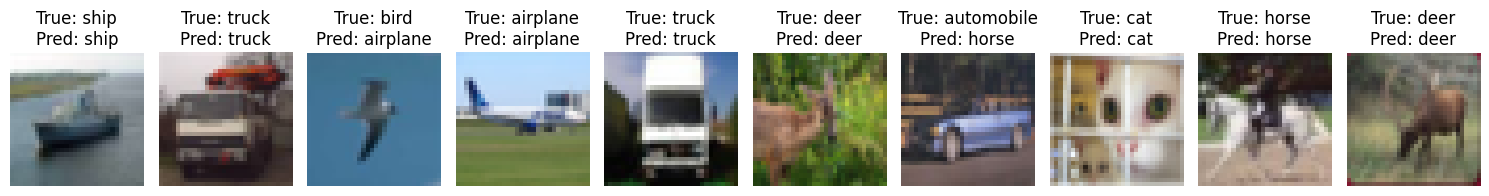

In [41]:
class_labels = [
    "airplane", "automobile", "bird", "cat", "deer",
    "dog", "frog", "horse", "ship", "truck"
]

model = ViT(image_size, patch_size, in_channels, in_embed_dims, out_embed_dims, num_heads, hidden_dims, num_transformers, num_classes)
PATH = "saved_models/vit/model_20250309_112343_191"
model.load_state_dict(torch.load(PATH, weights_only=True))
model = model.to(device)

test_and_display_random_images(model, testset, num_images=10, class_labels=class_labels, device=device)